## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for model tuning and splitting the data into train and test
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [2]:
#Importing the training and test dataset
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

## Data Overview

The initial steps to get an overview of any dataset is to: 
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [3]:
#shape of the training data
df_train.shape

(20000, 41)

In [4]:
#shape of the test data
df_test.shape

(5000, 41)

### Creating the copy of all the data sets

In [5]:
#Creating the copy of training data
data_train = df_train.copy()

In [6]:
#Creating the copy of test data
data_test = df_test.copy()

### Displaying the first few rows of the datasets

In [7]:
# First five rows of training data
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [8]:
#First five rows of the test data
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


### Checking the data types of the columns for the dataset

In [9]:
#data types of the training data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [10]:
#data types of the test data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

### As seen from the data information all the data types in the Training and Test data are float

### Checking for duplicate values

In [11]:
#duplicate values for training data
data_train.duplicated().sum()

0

In [12]:
#duplicate values for test data
data_test.duplicated().sum()

0

### There are no duplicate values in the Training and Test data

### Checking for missing values

In [13]:
#missing values in the training data
data_train.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [14]:
#missing values in the test data
data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

### 
* There are total of 18 missing values in the feature `V1`and `V2` of the training data set
* Meanwhile there are 5 missing values the feature `V1` and 6 missing values in feature `V2` of the test data

### Statistical summary of the dataset

In [15]:
#statistical summary of the training data
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


In [16]:
#statistical summary of the test data
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,4995.000,-0.278,3.466,-12.382,-2.744,-0.765,1.831,13.504
V2,4994.000,0.398,3.140,-10.716,-1.649,0.427,2.444,14.079
V3,5000.000,2.552,3.327,-9.238,0.315,2.260,4.587,15.315
V4,5000.000,-0.049,3.414,-14.682,-2.293,-0.146,2.166,12.140
V5,5000.000,-0.080,2.111,-7.712,-1.615,-0.132,1.341,7.673
V6,5000.000,-1.042,2.005,-8.924,-2.369,-1.049,0.308,5.068
V7,5000.000,-0.908,1.769,-8.124,-2.054,-0.940,0.212,7.616
V8,5000.000,-0.575,3.332,-12.253,-2.642,-0.358,1.713,10.415
V9,5000.000,0.030,2.174,-6.785,-1.456,-0.080,1.450,8.851
V10,5000.000,0.019,2.145,-8.171,-1.353,0.166,1.511,6.599


### Observations on the Training and Test Data
* There are total of 20000 observations with 40 dependent features and 1 traget variable in the Training Data
* There are total of 5000 observations with 40 dependent features and 1 traget variable in the Test Data
* The mean value for the traget variable is same 0.056 in both Training and Test Data

## Exploratory Data Analysis

### Univariate analysis

In [17]:
# function for plotting the histogram with boxplot

def hist_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

#### Plotting histograms and boxplots for all the variables

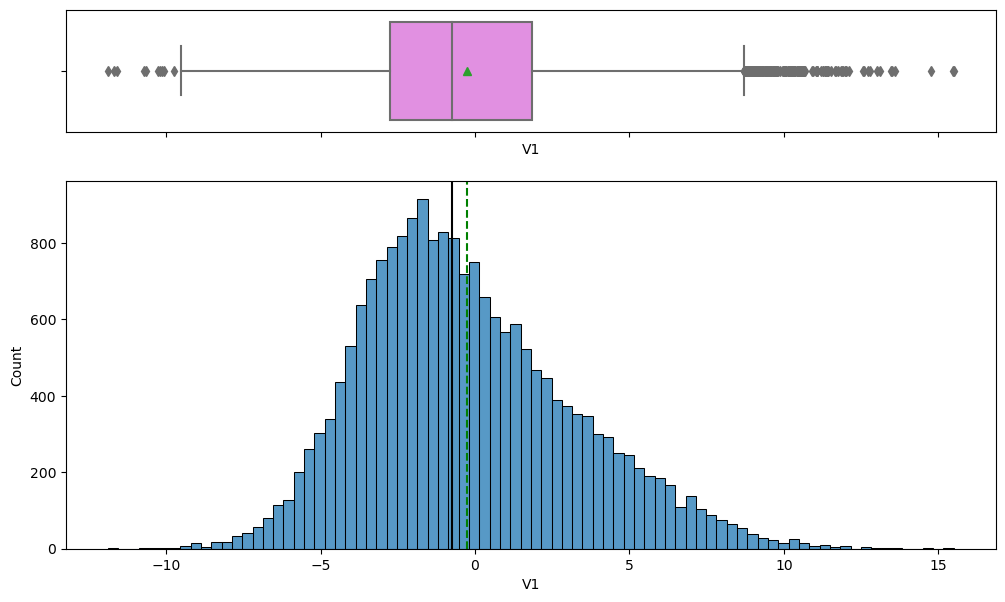

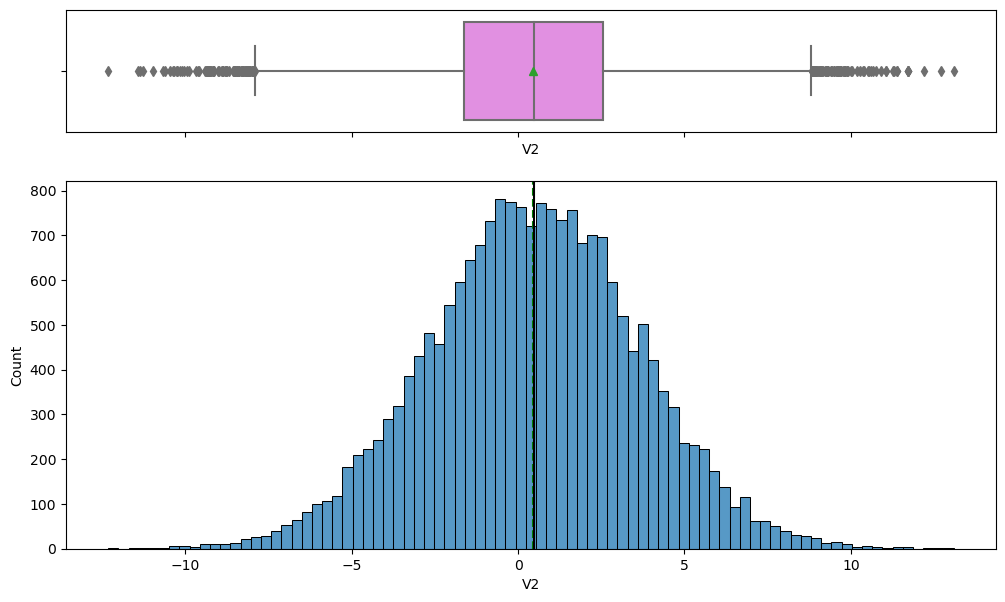

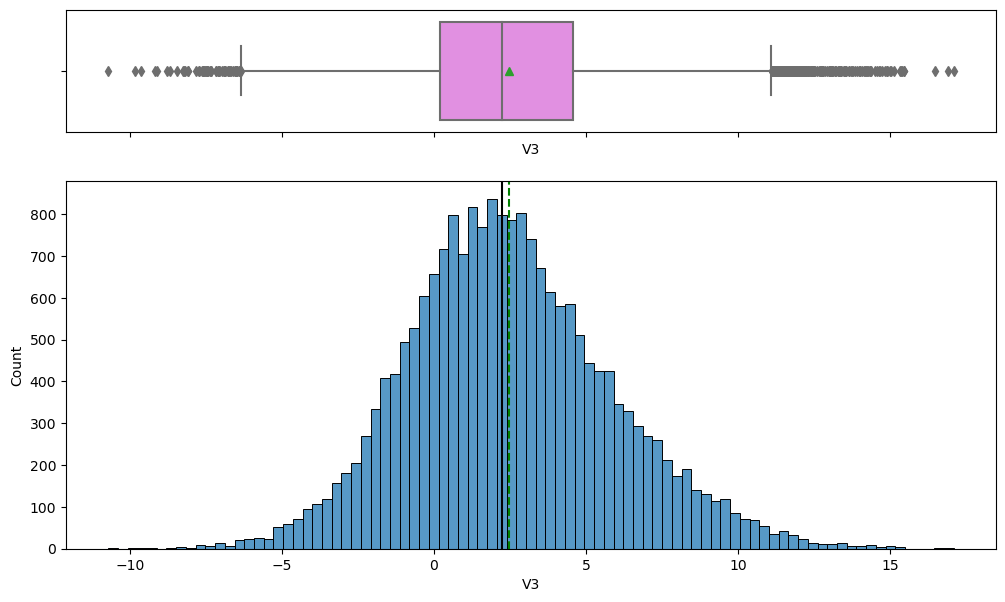

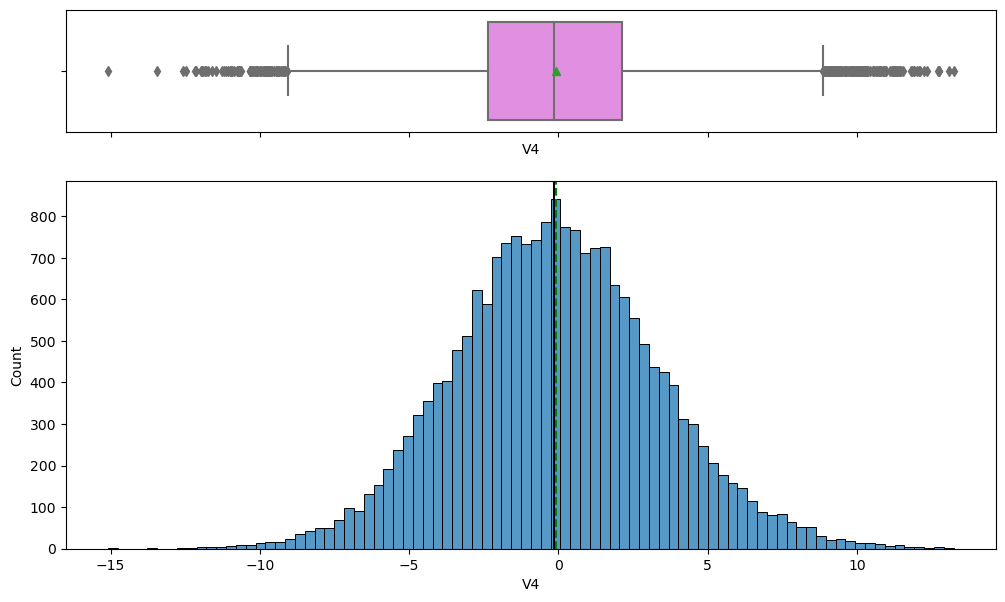

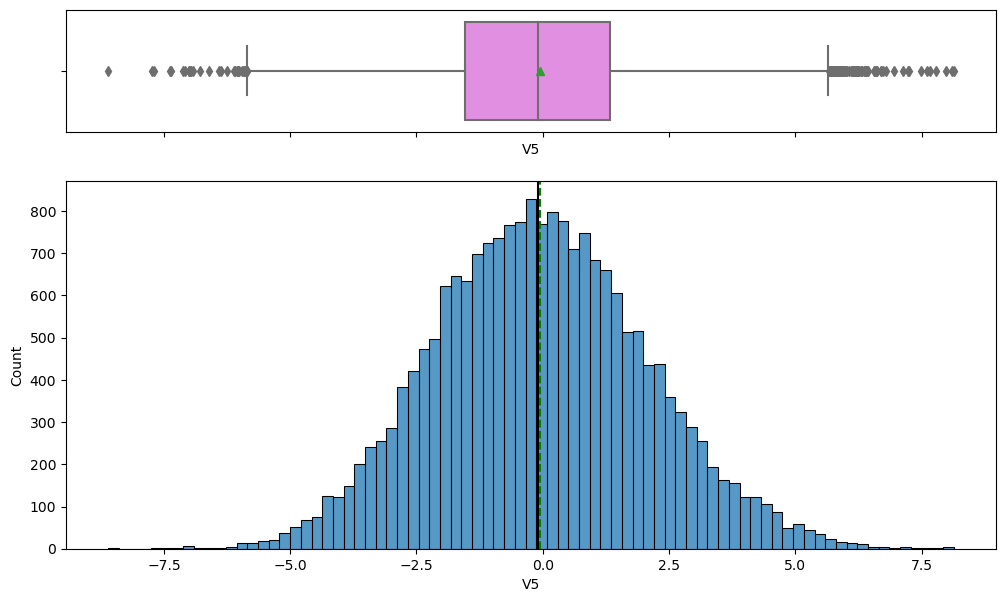

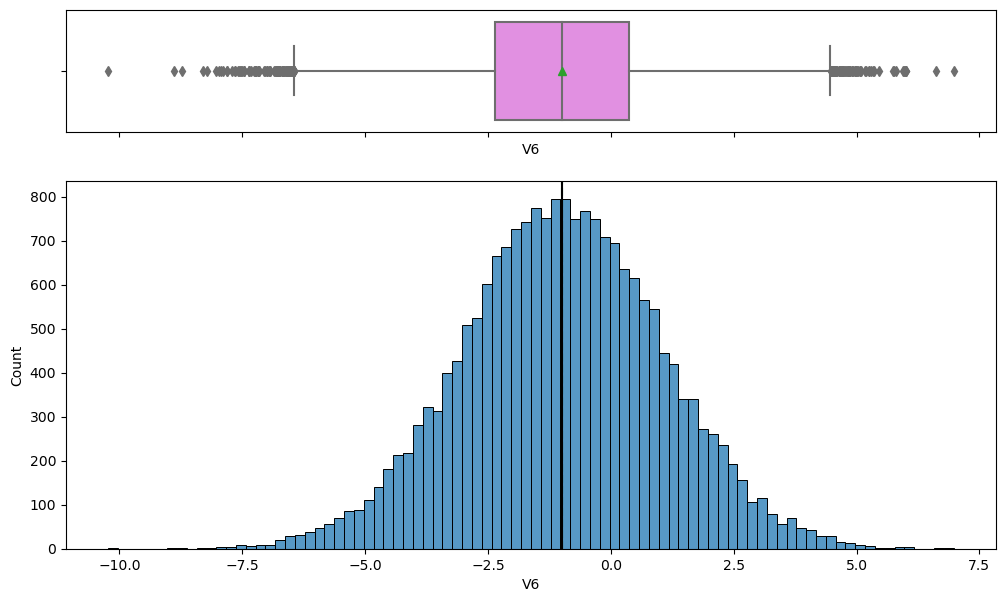

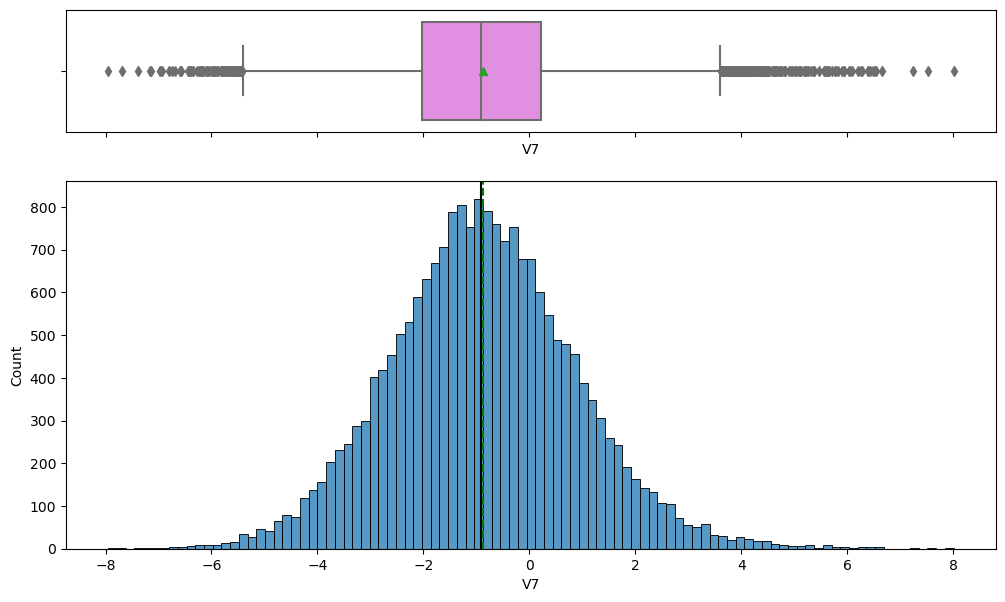

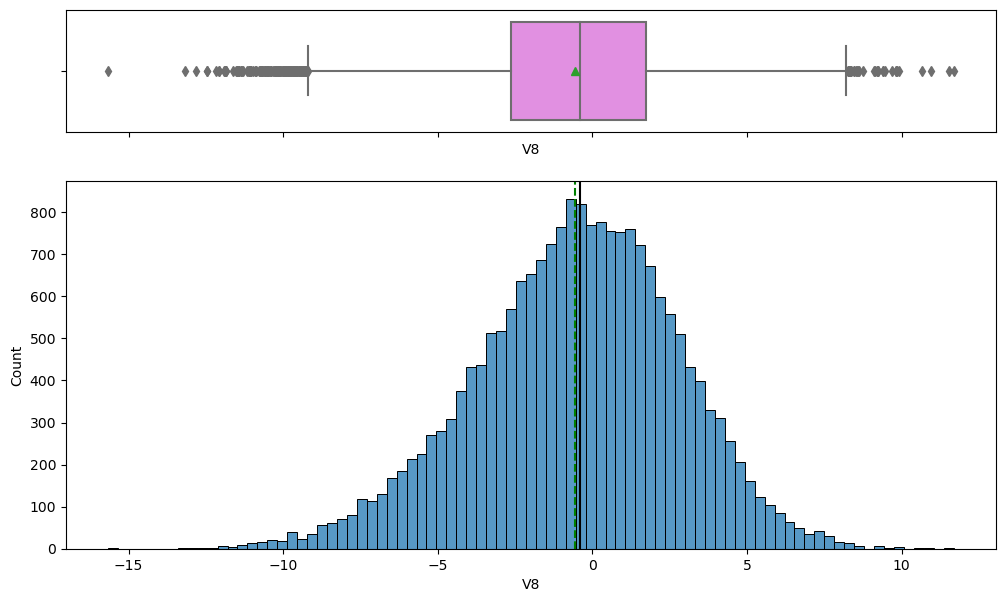

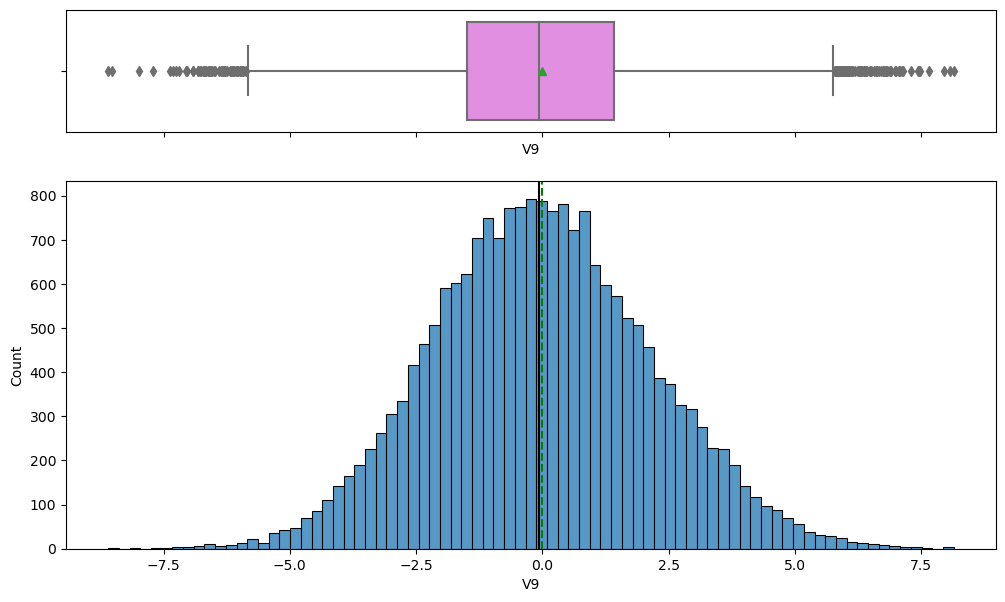

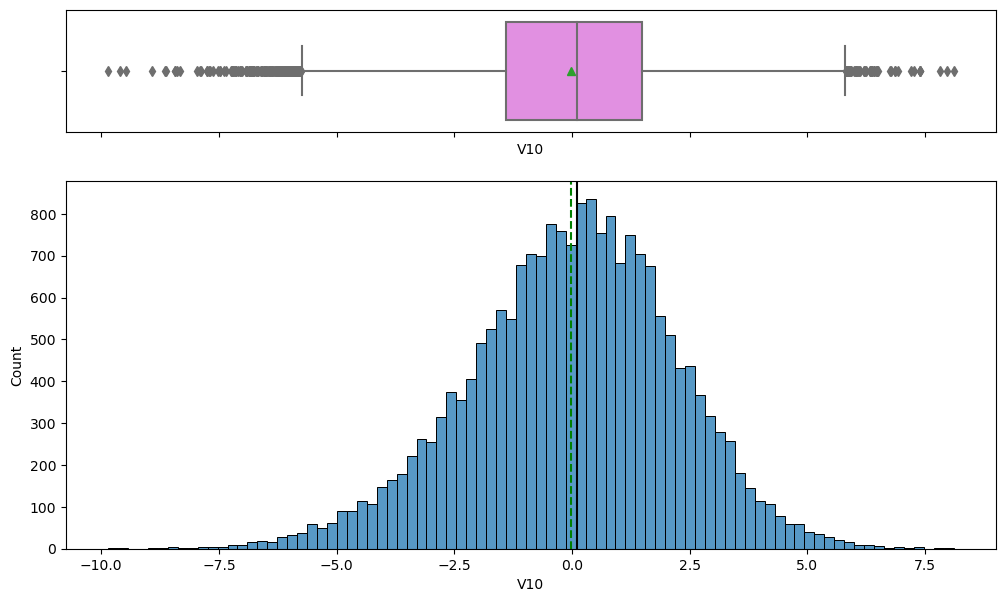

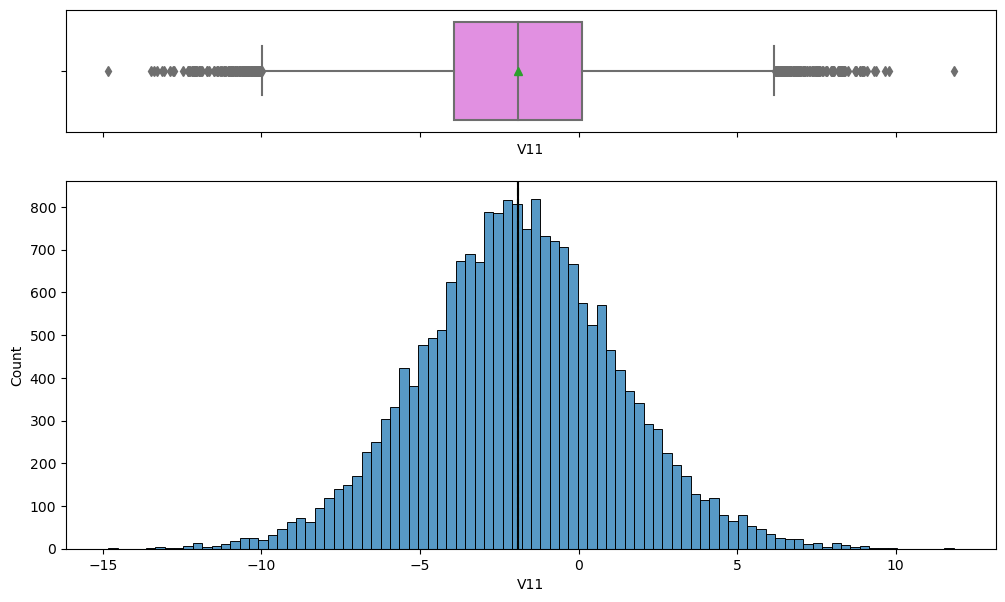

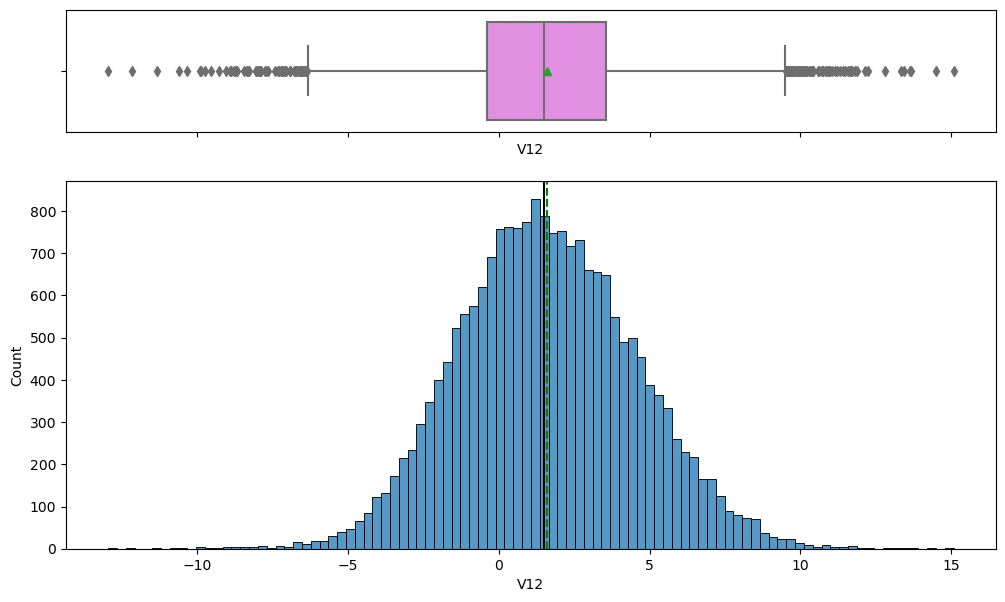

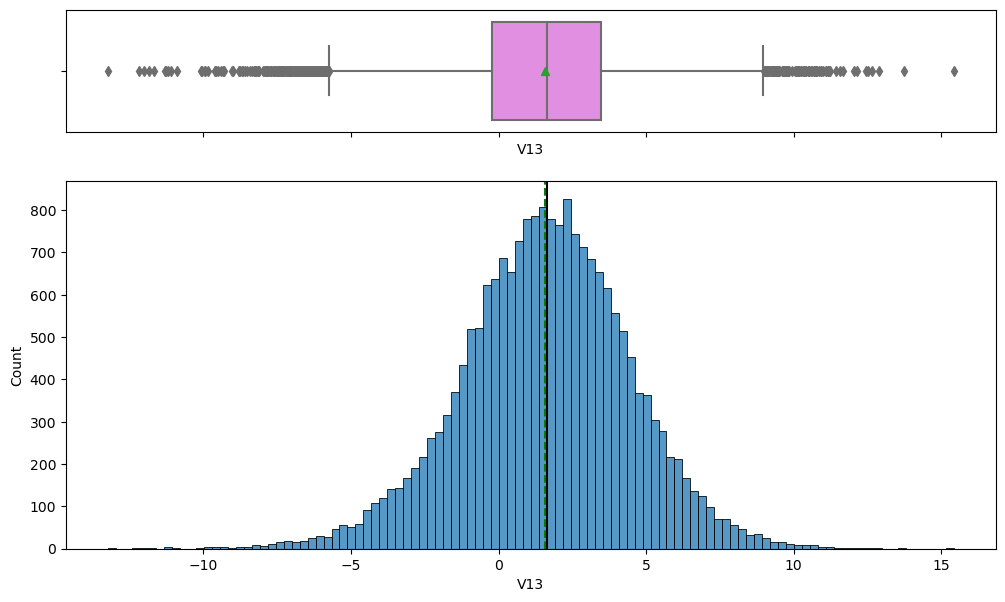

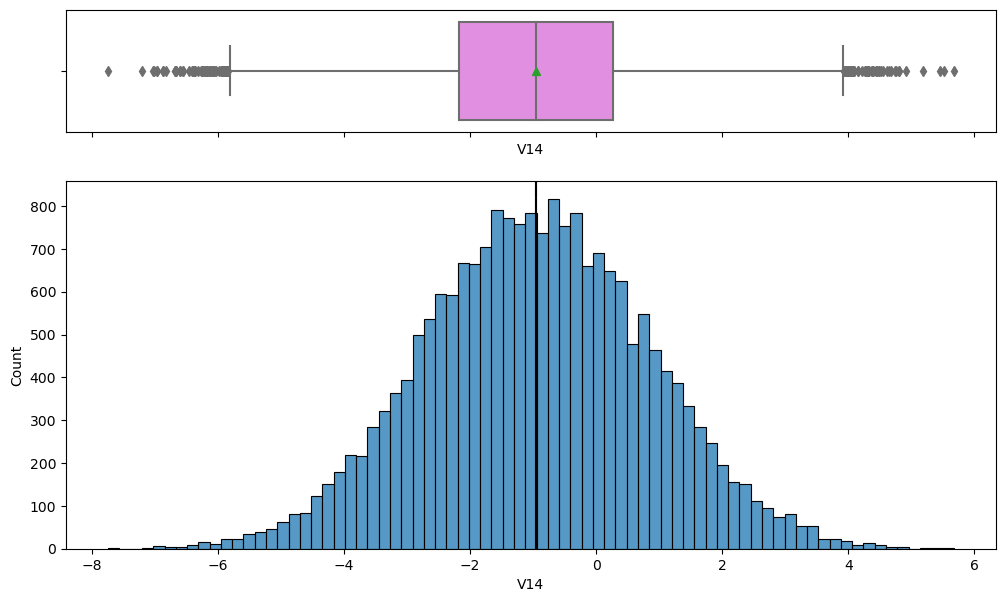

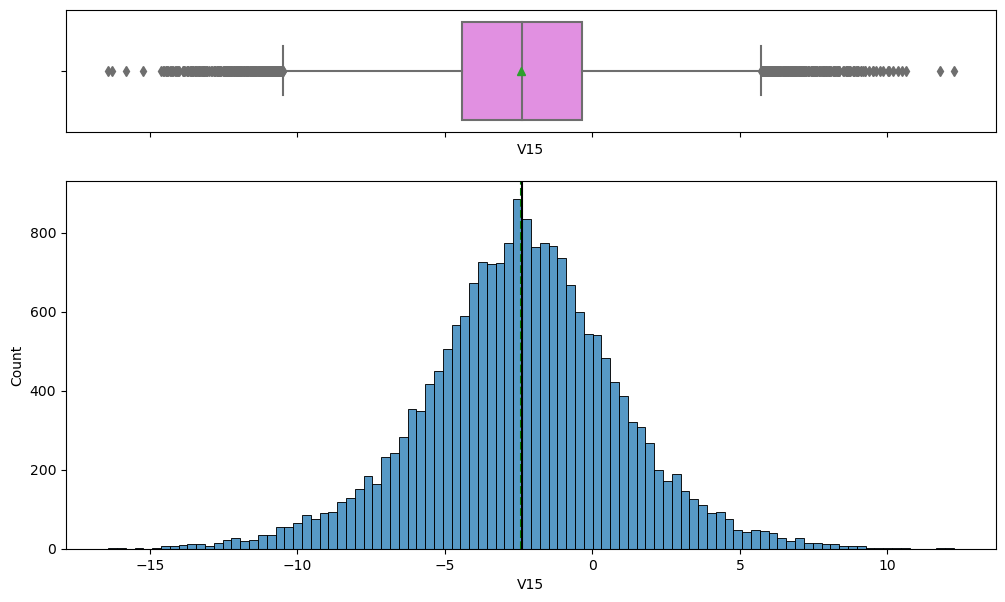

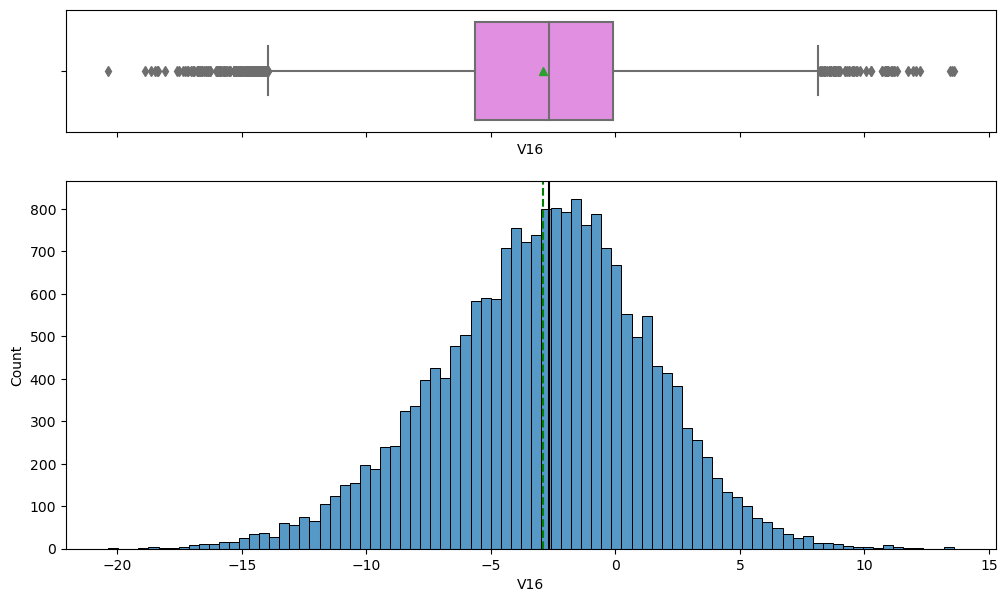

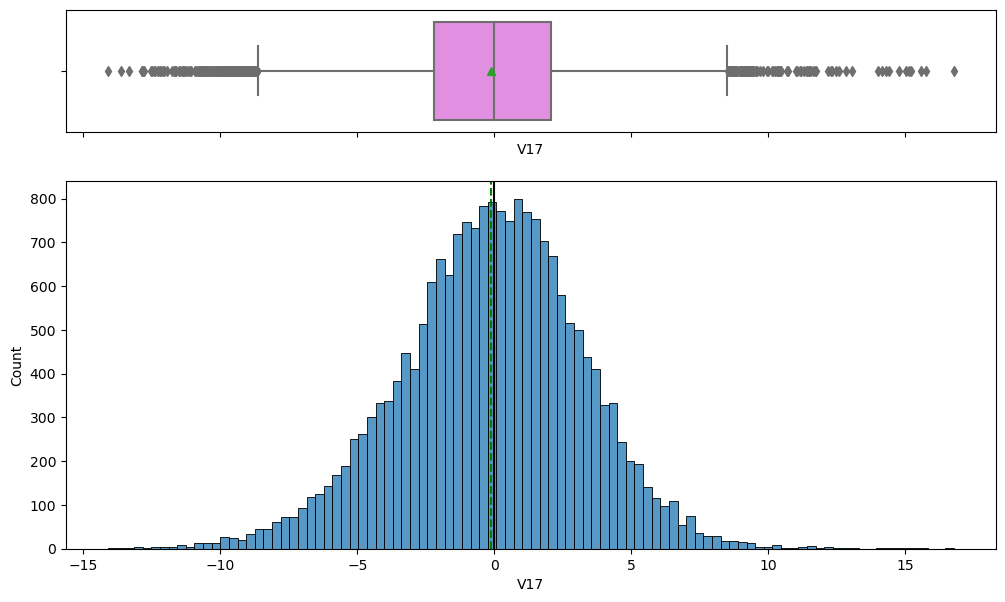

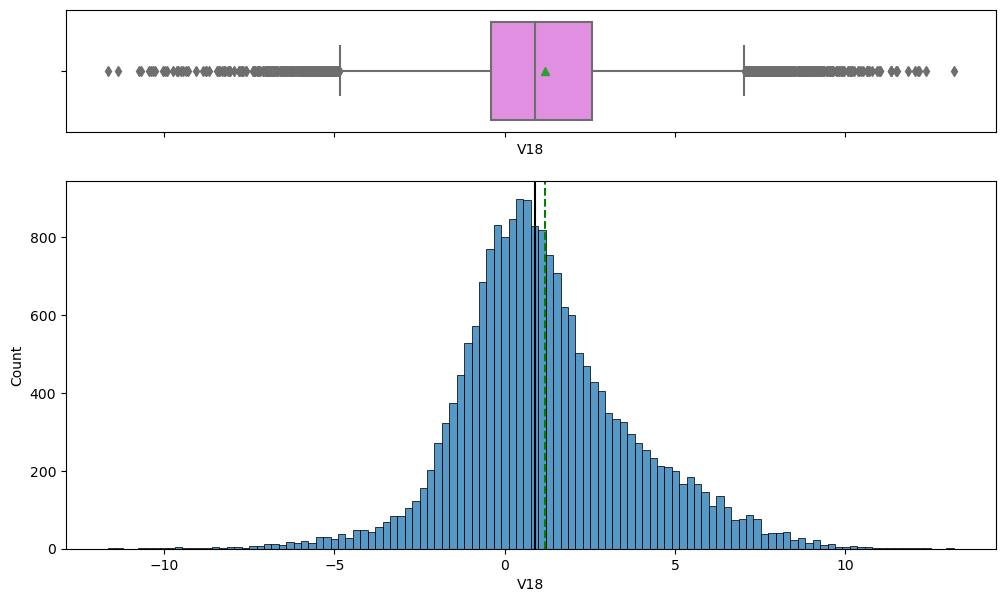

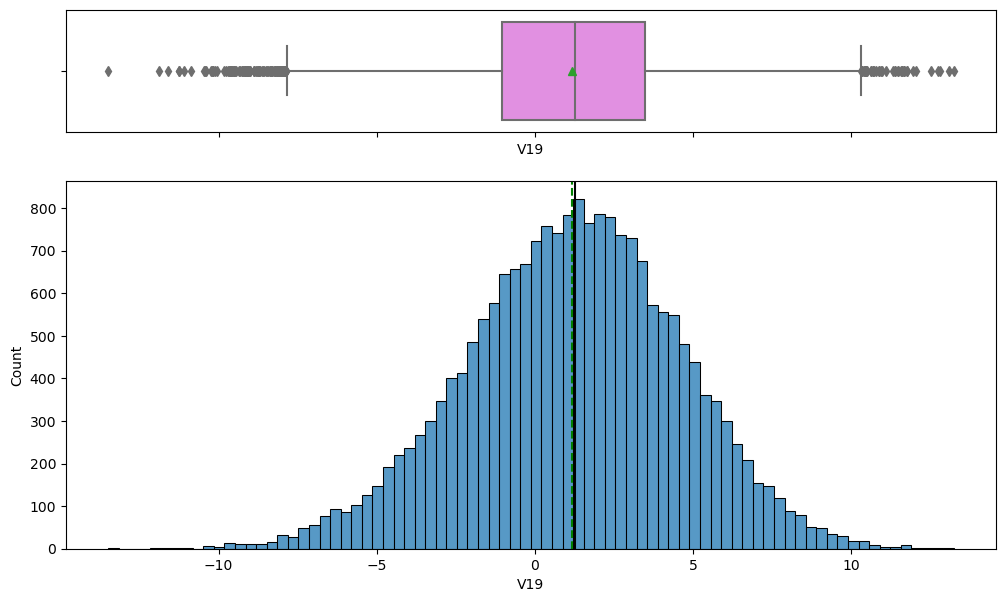

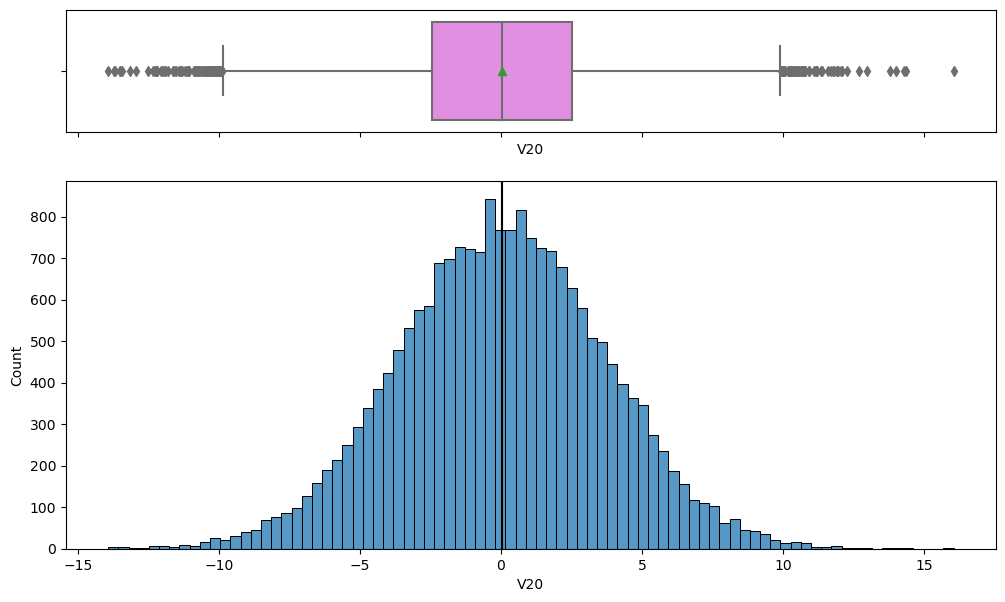

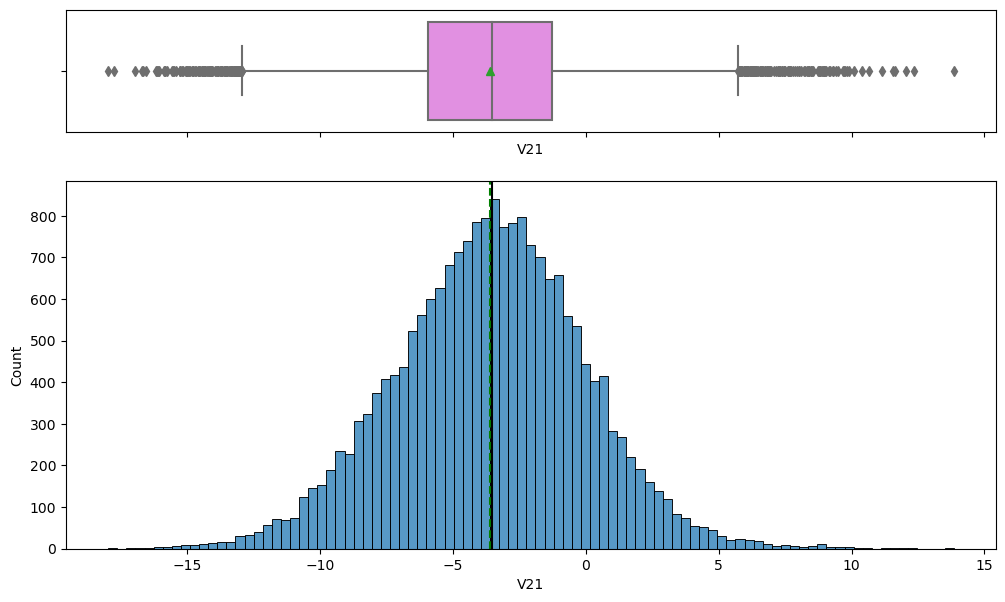

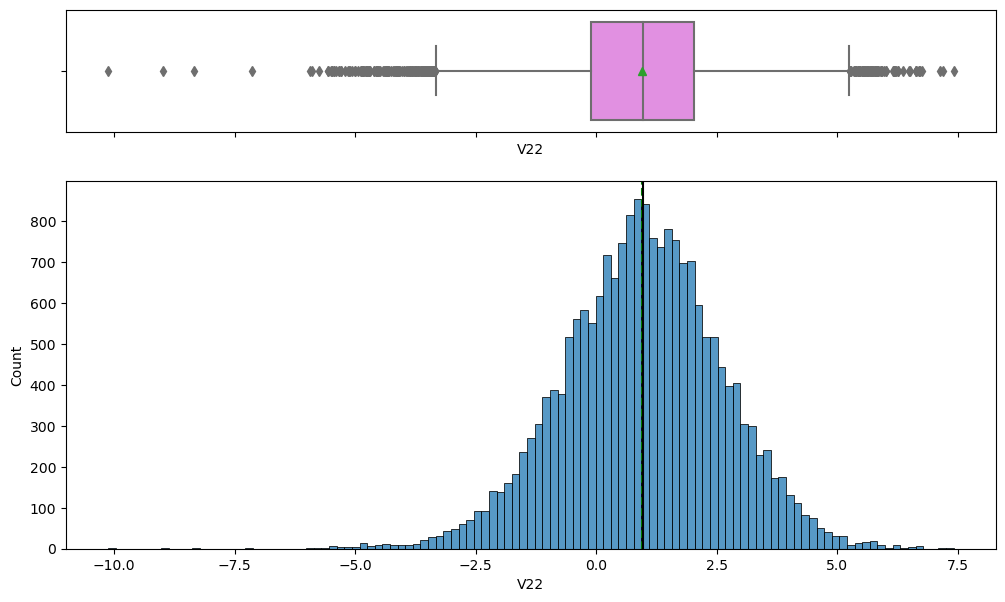

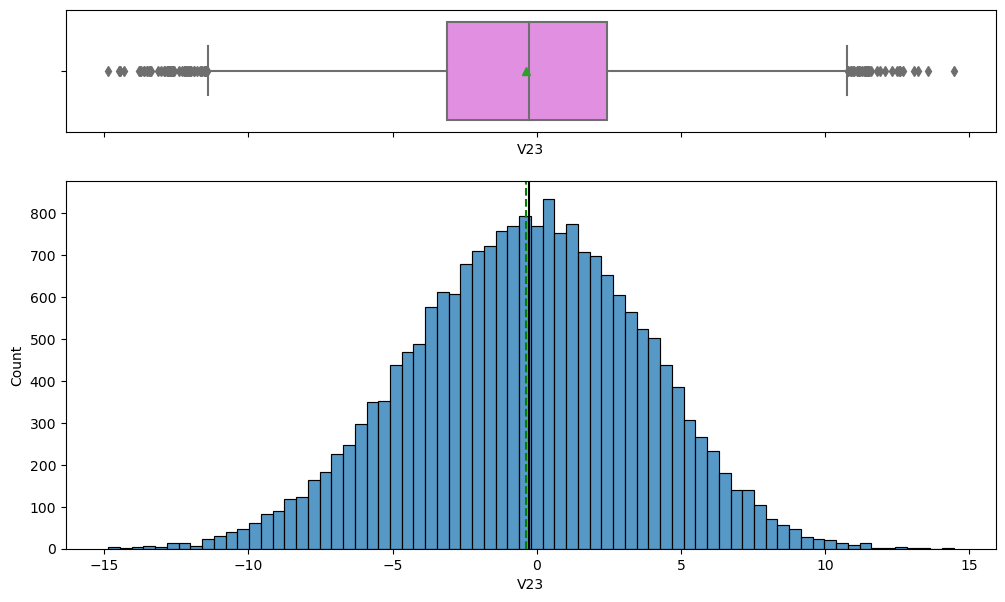

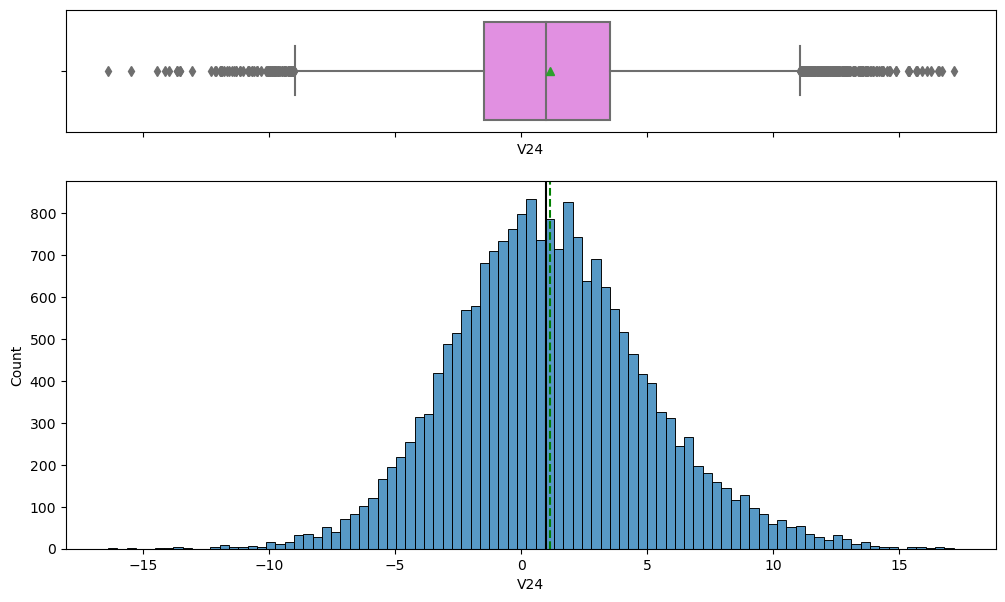

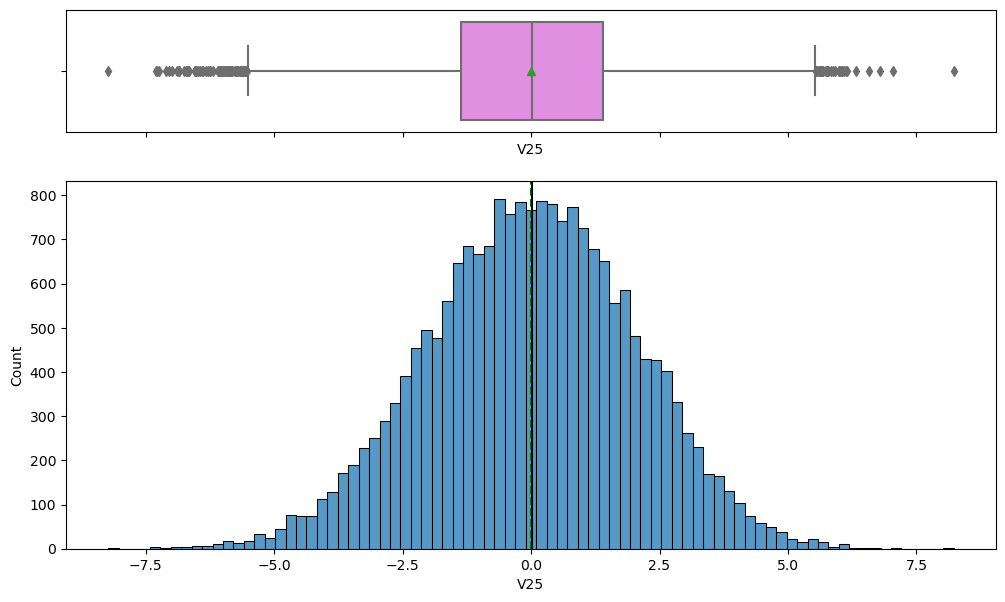

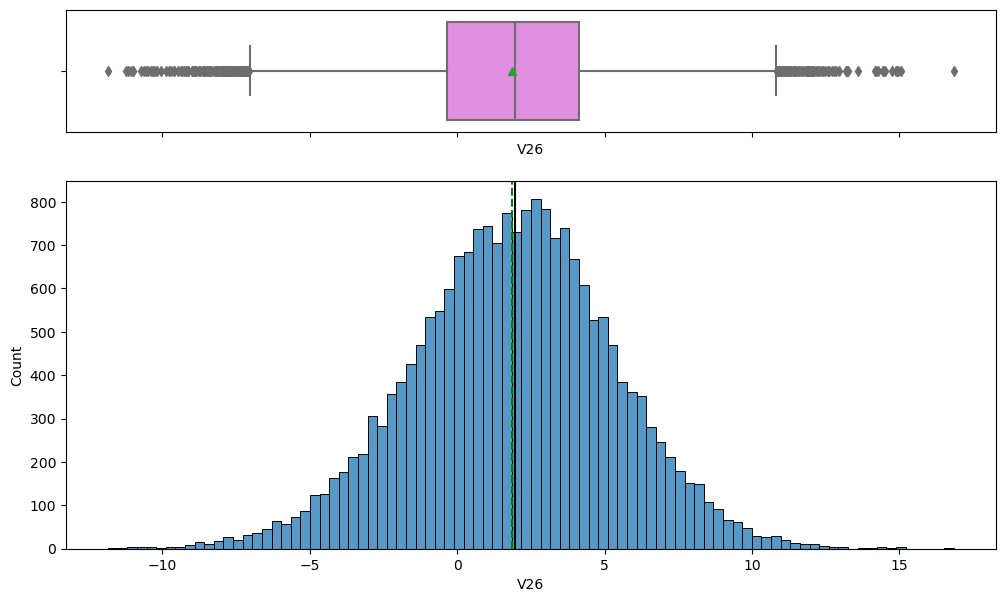

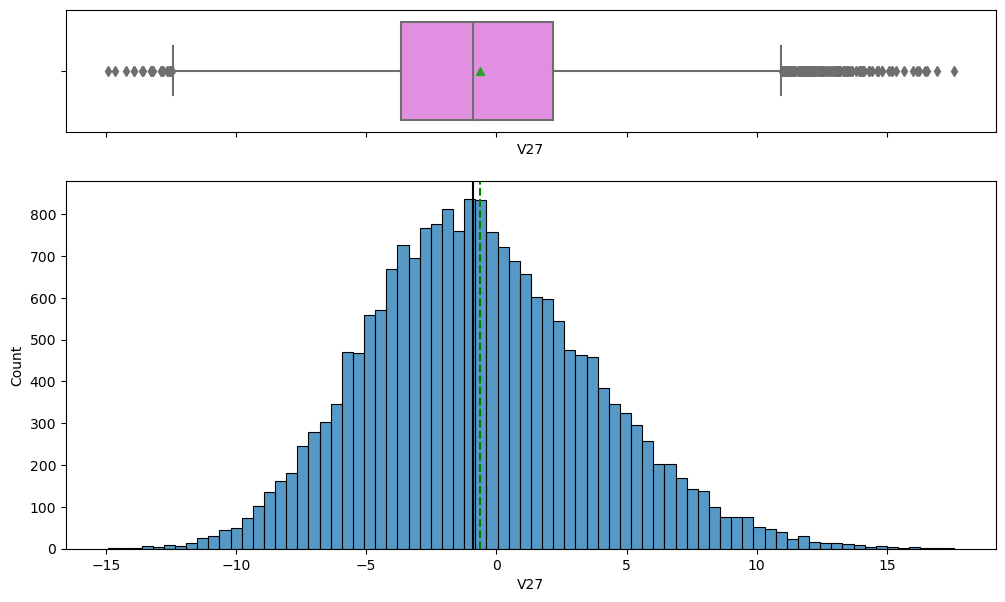

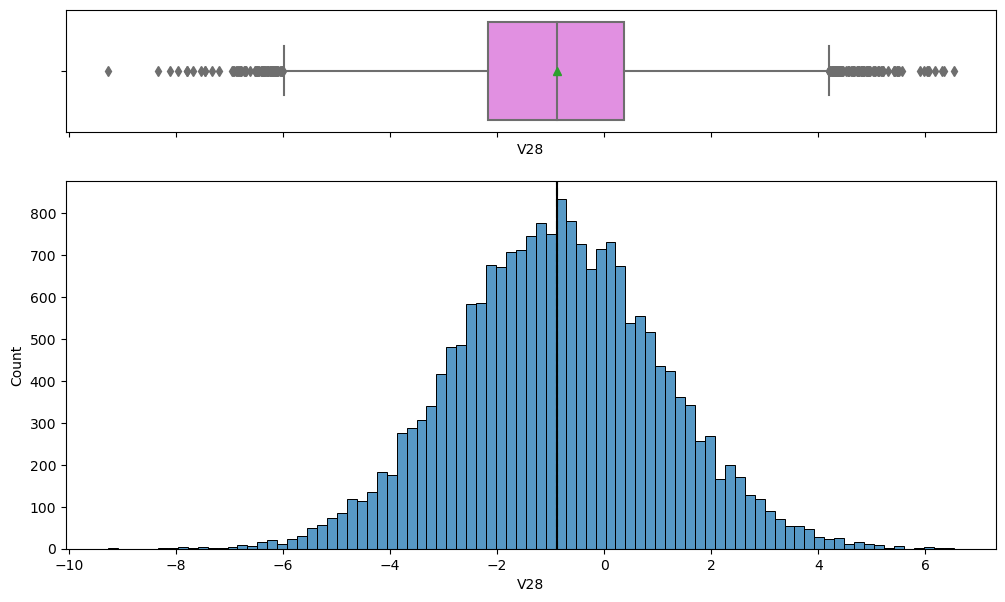

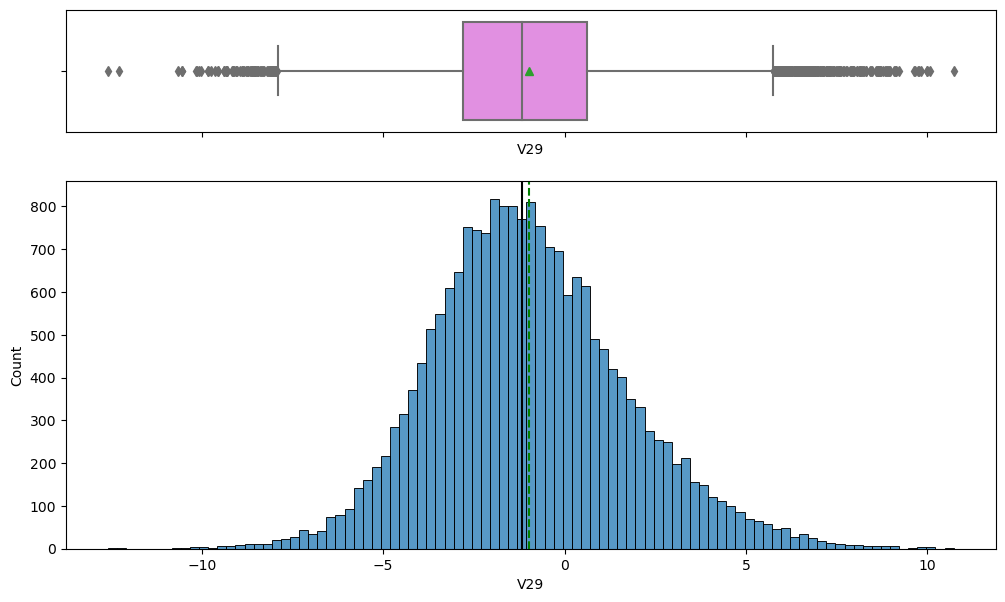

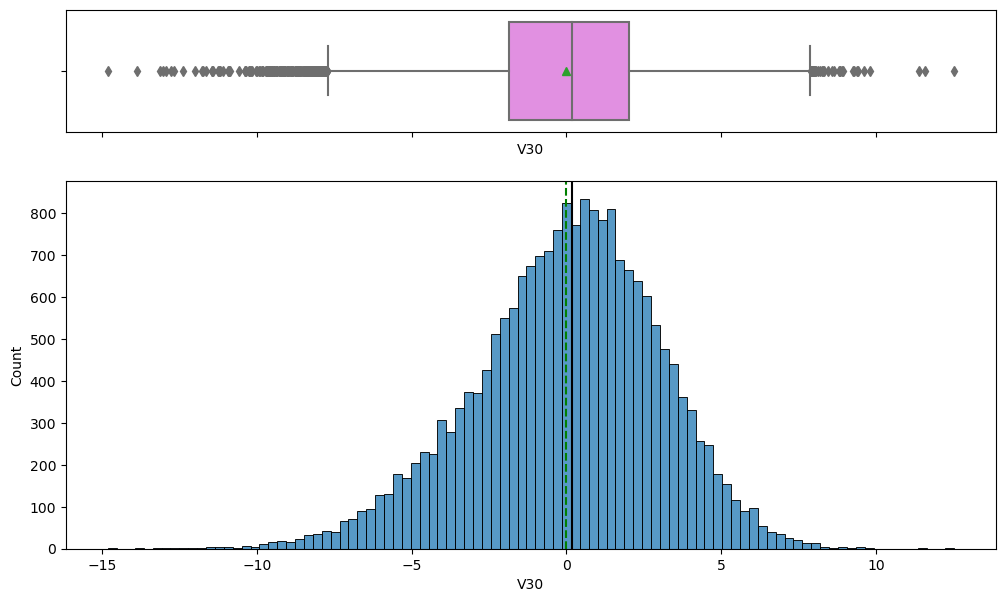

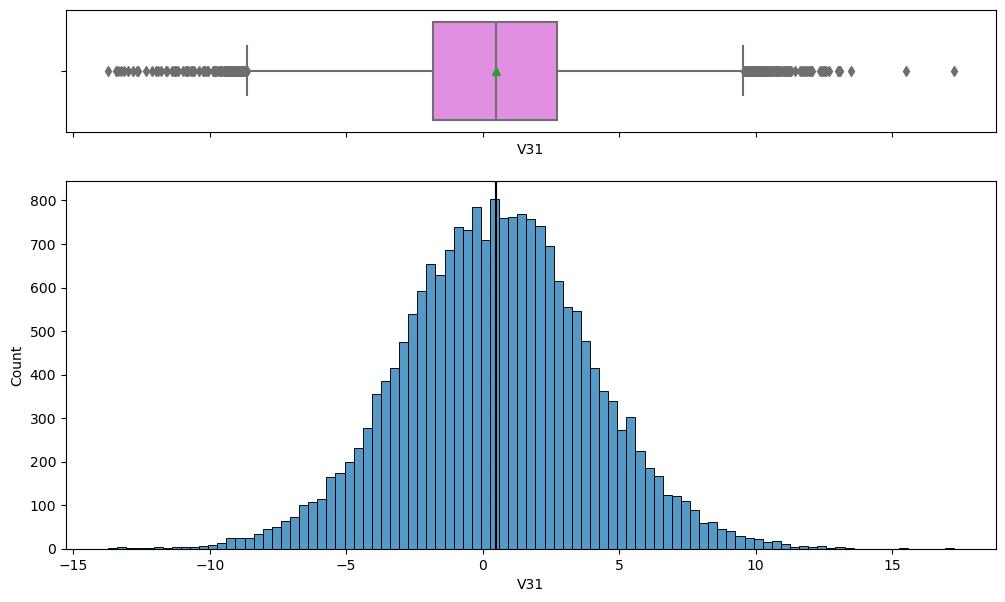

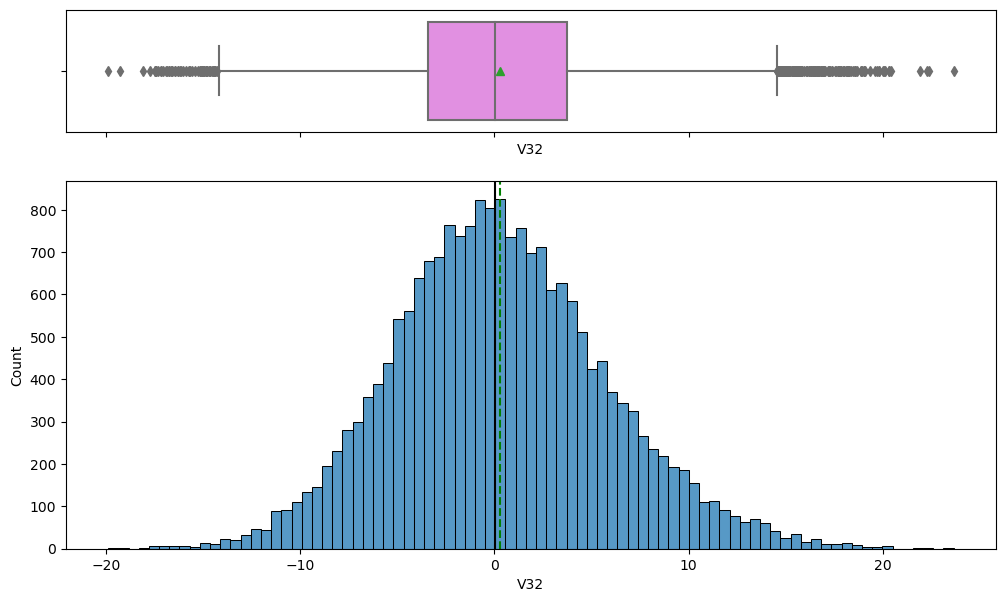

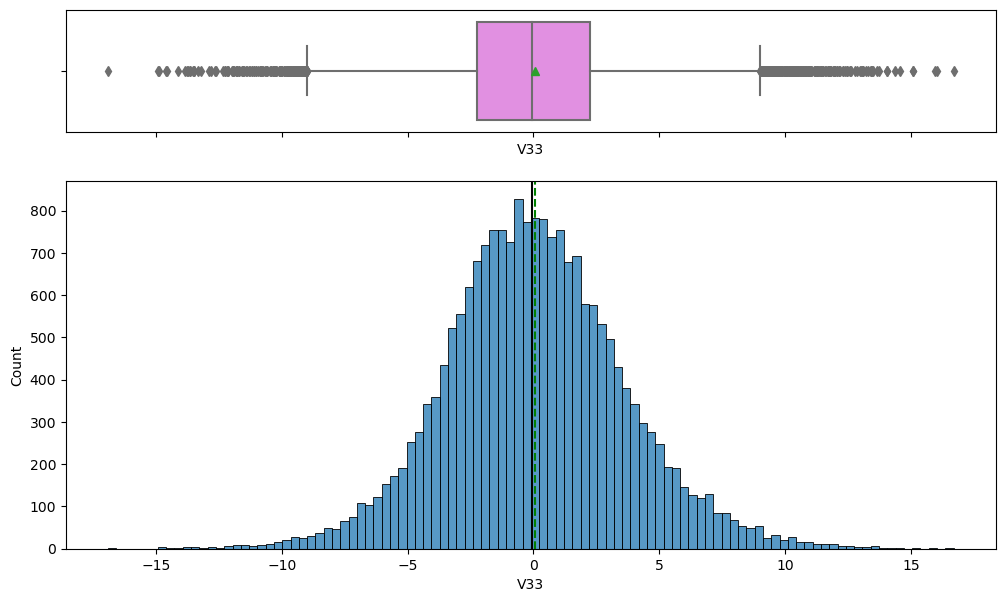

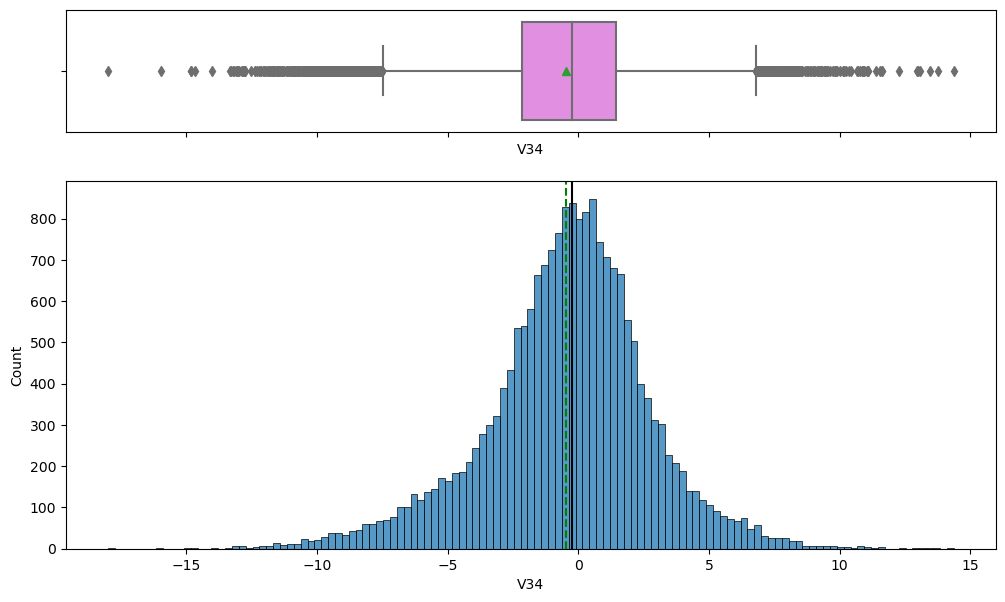

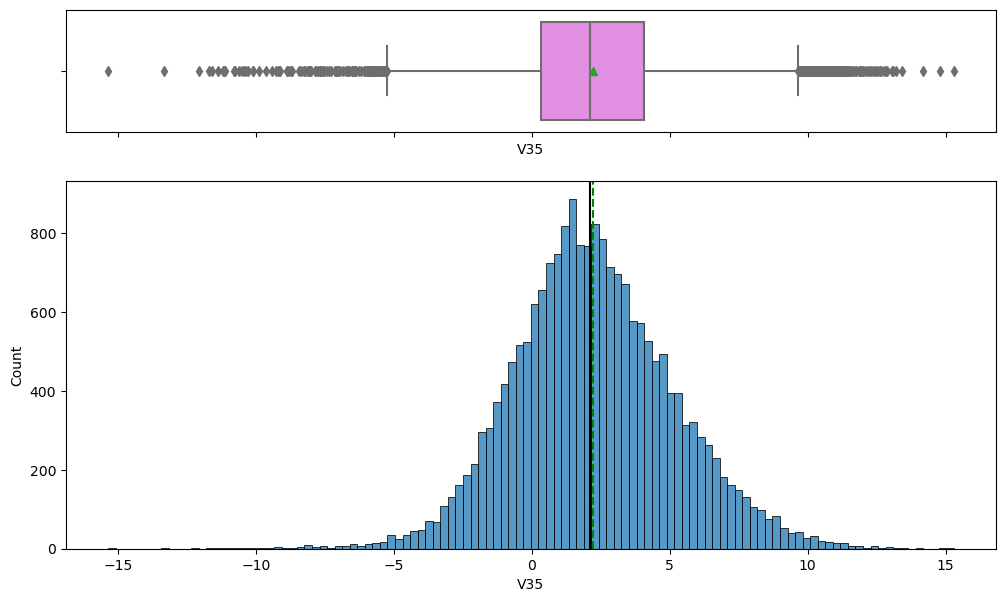

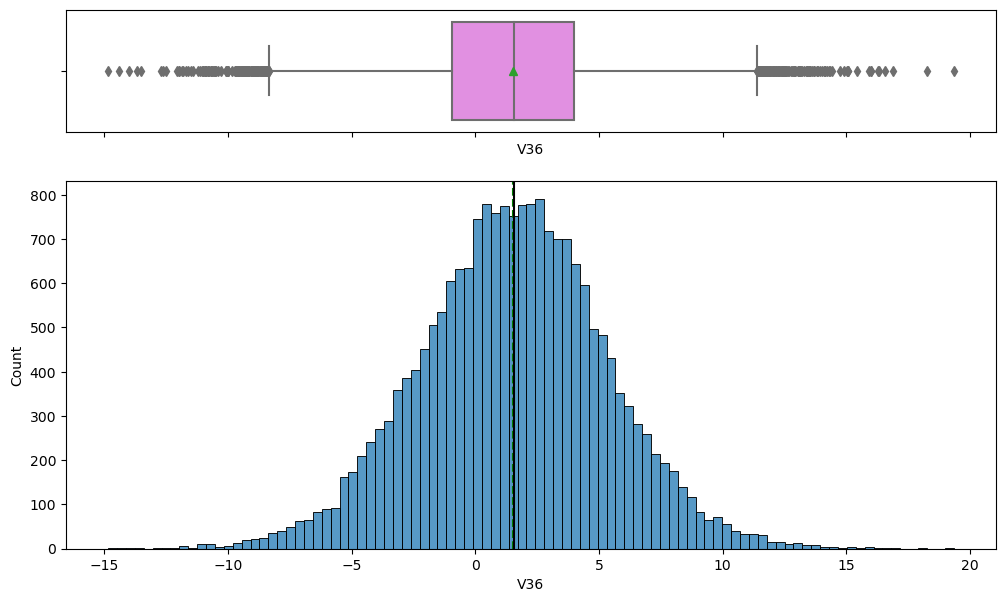

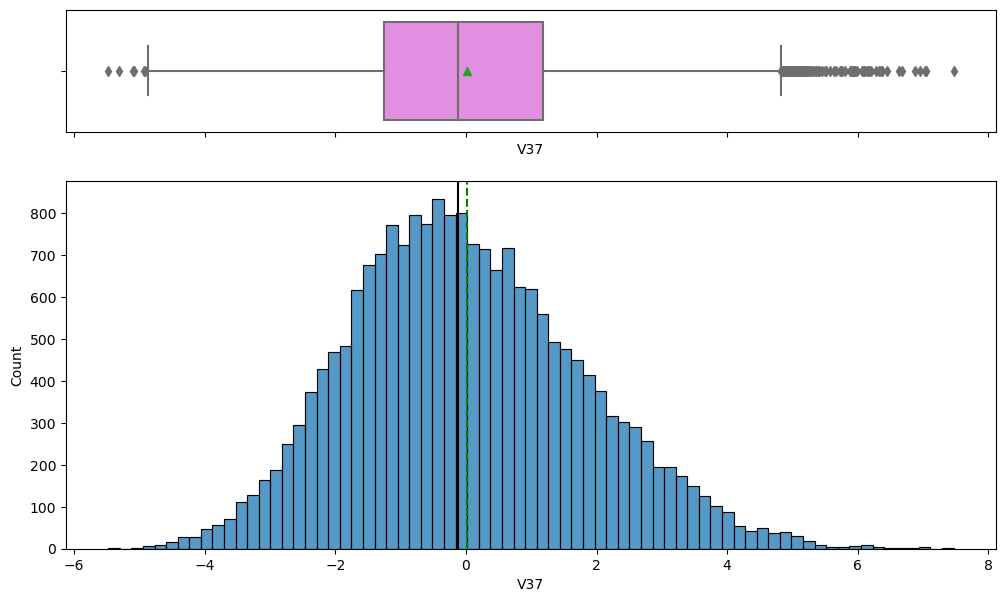

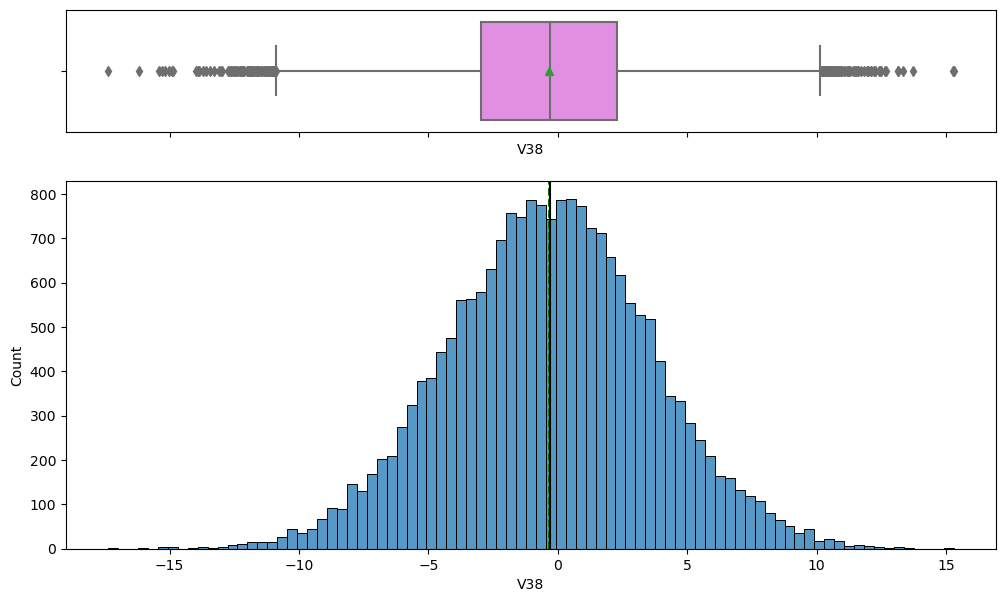

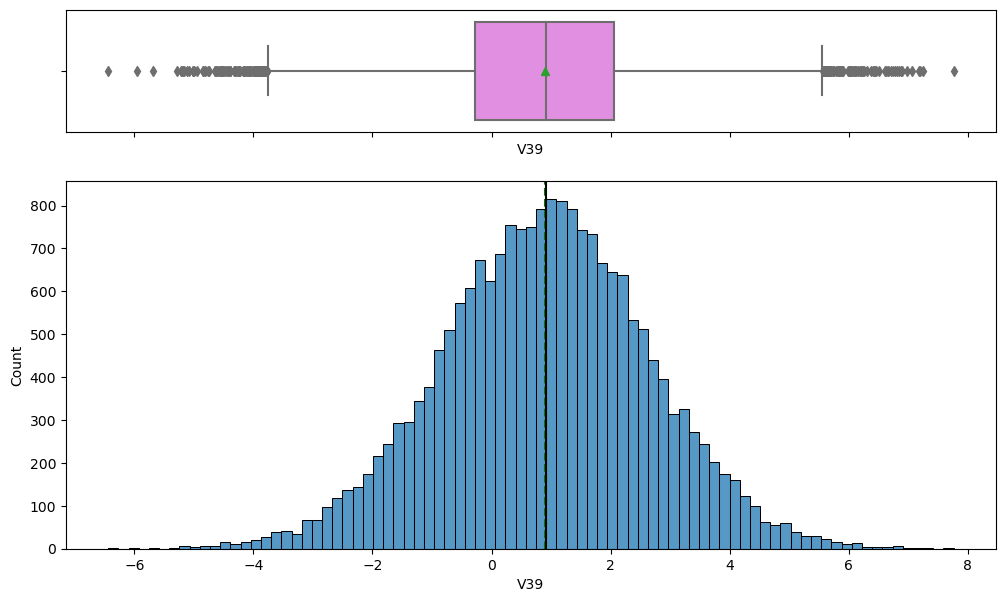

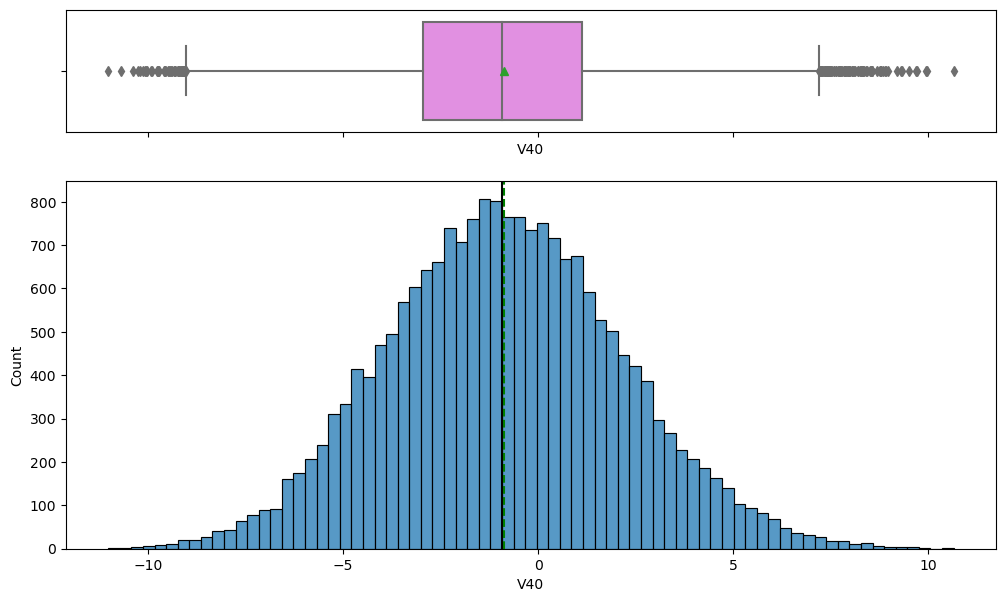

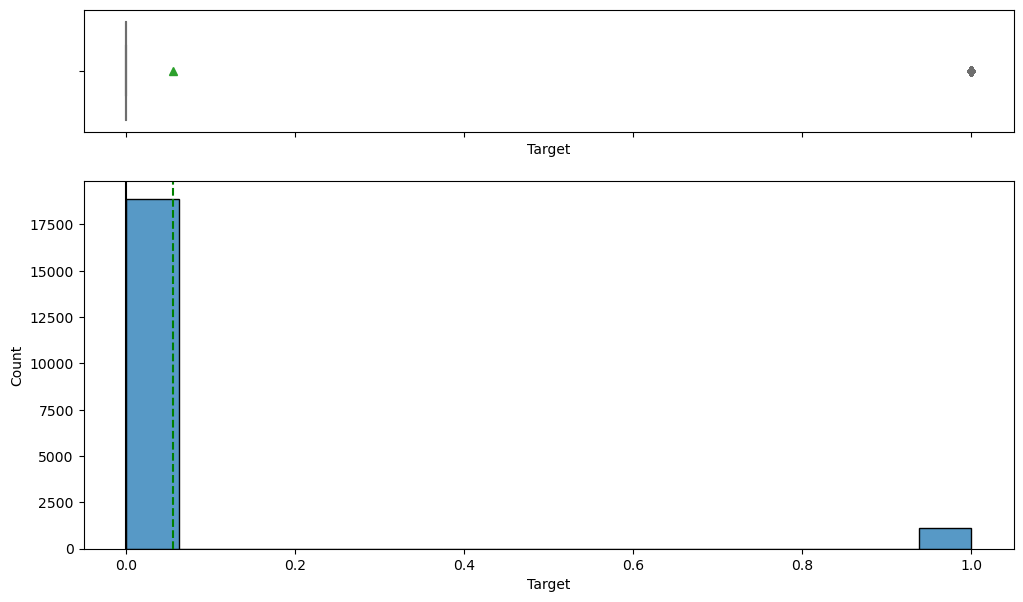

In [18]:
#plotting the histogram and boxplot for the training data
for feature in data_train.columns:
    hist_boxplot(data_train, feature, figsize=(12, 7), kde=False, bins=None)
    plt.show()

### As we can see from the graphs, almost all the variables in the data are normally distributed for Training Data

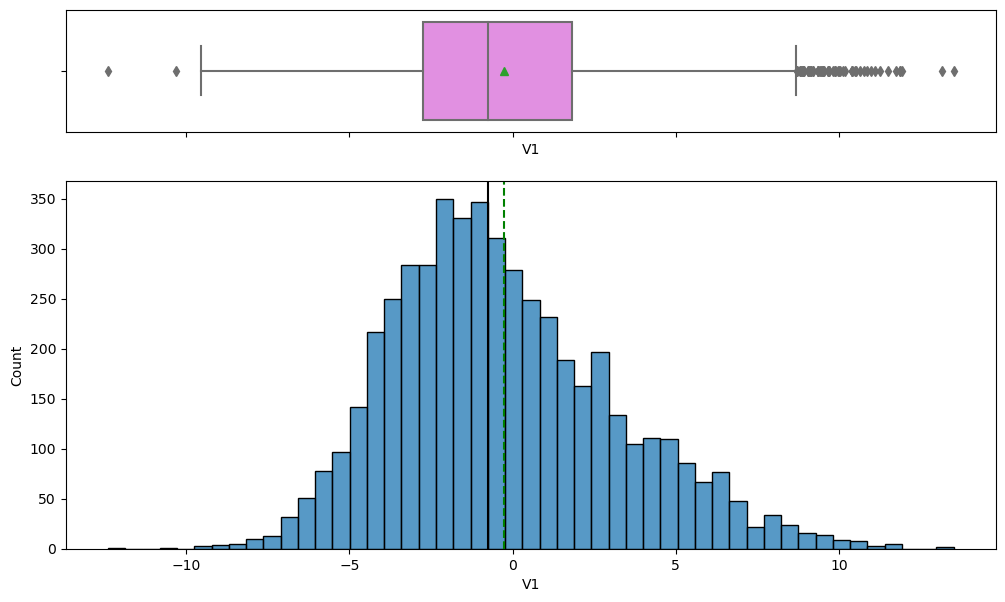

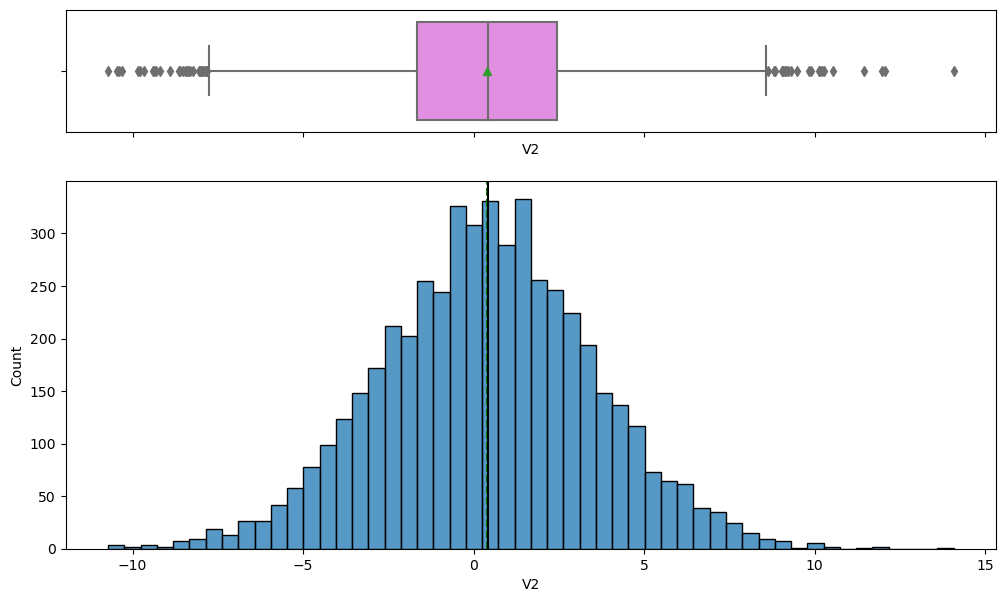

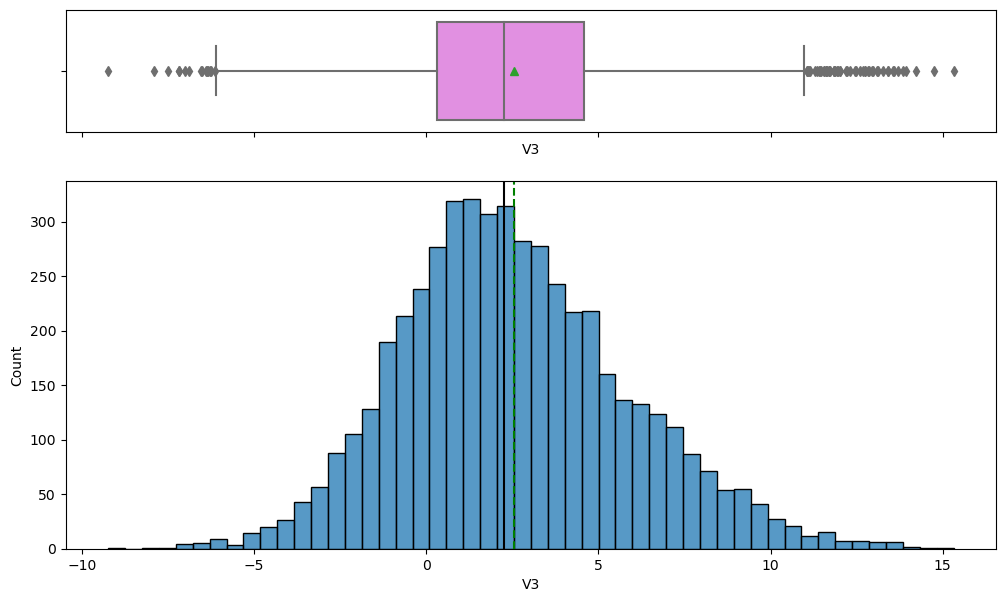

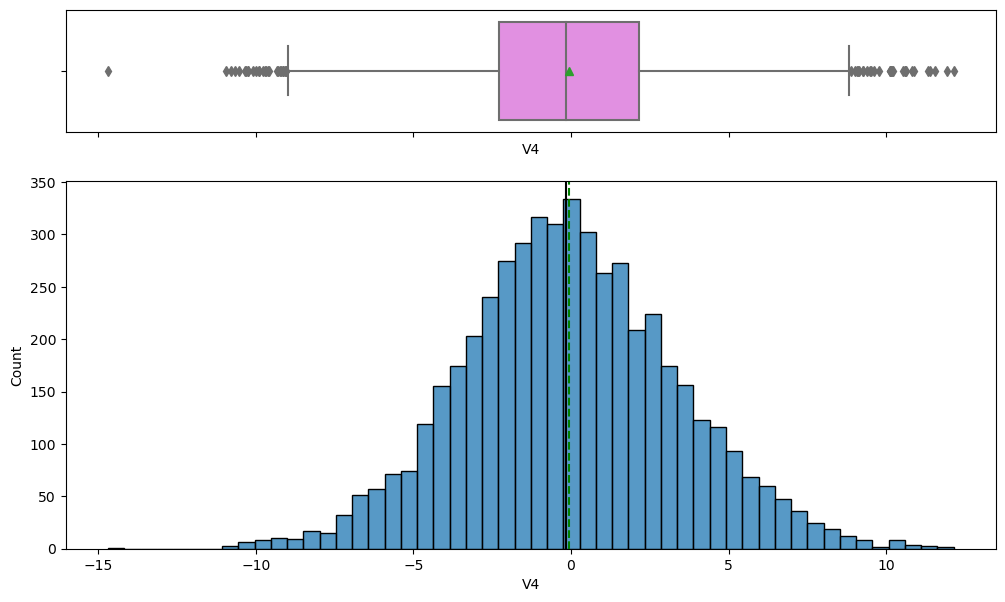

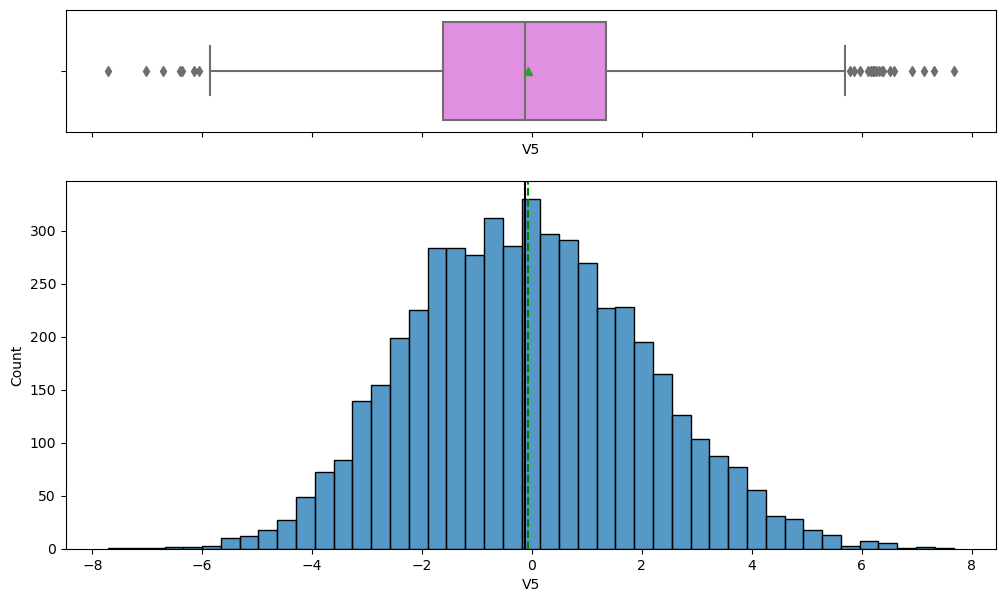

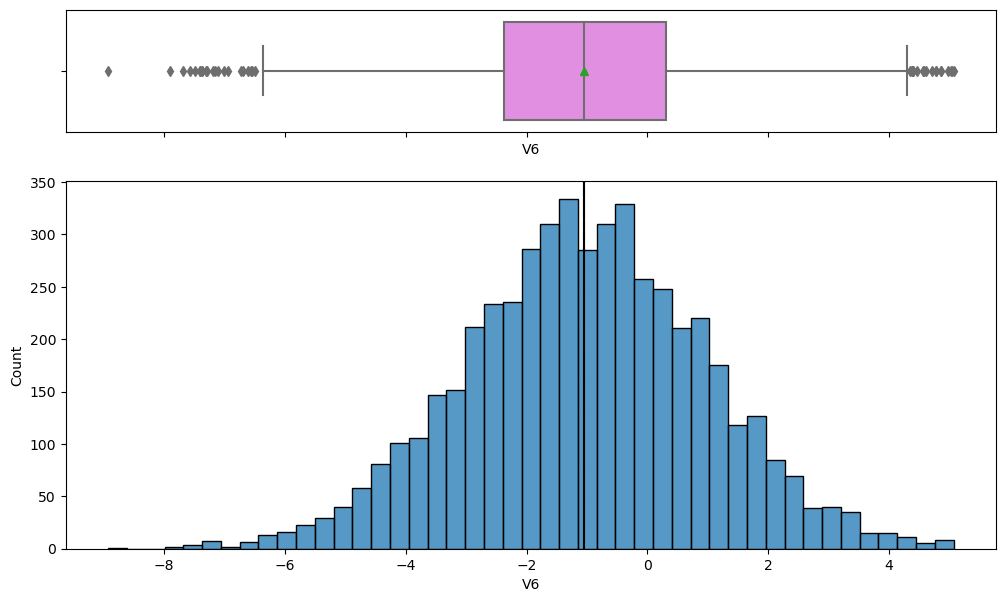

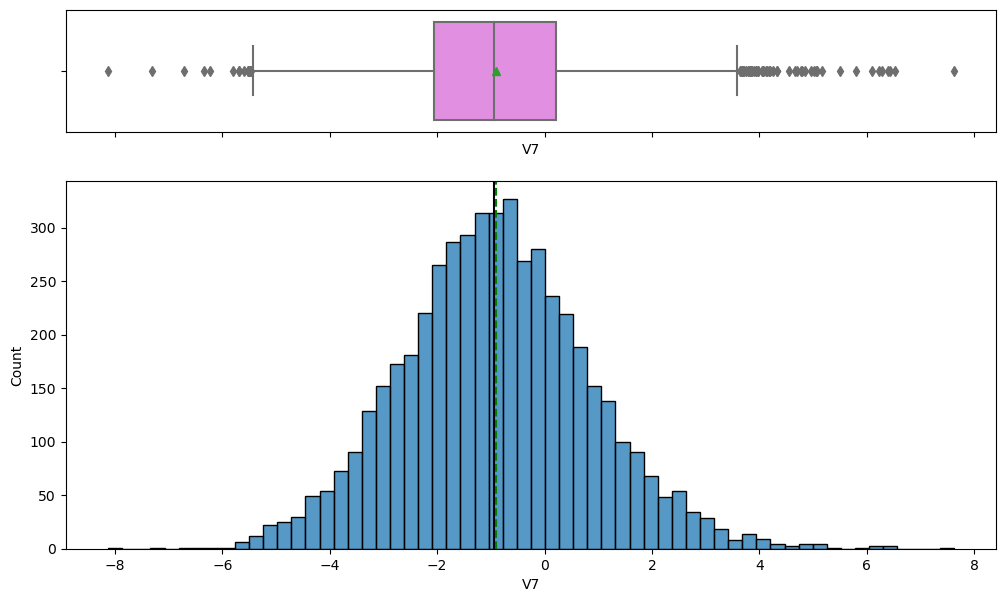

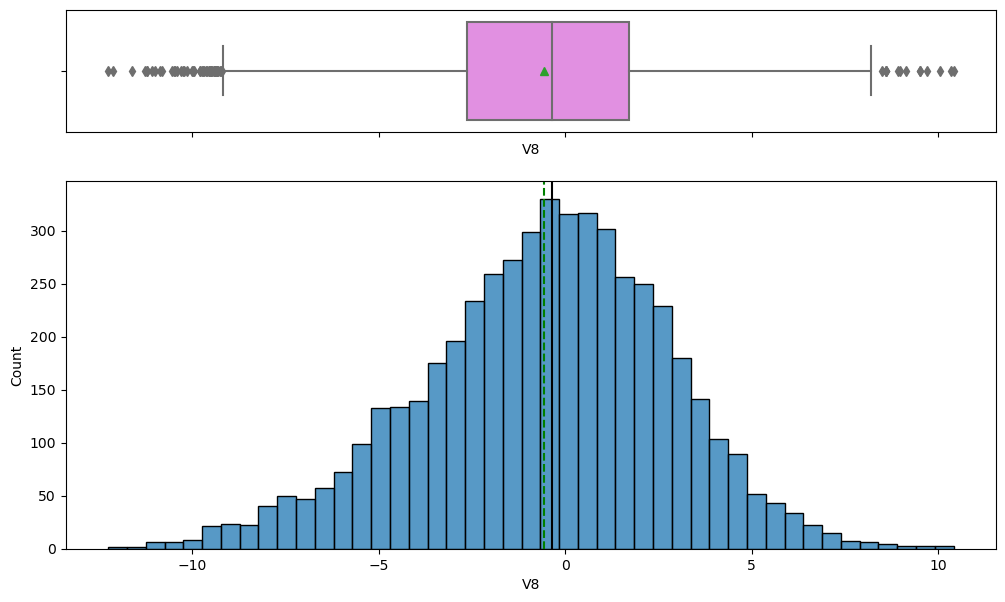

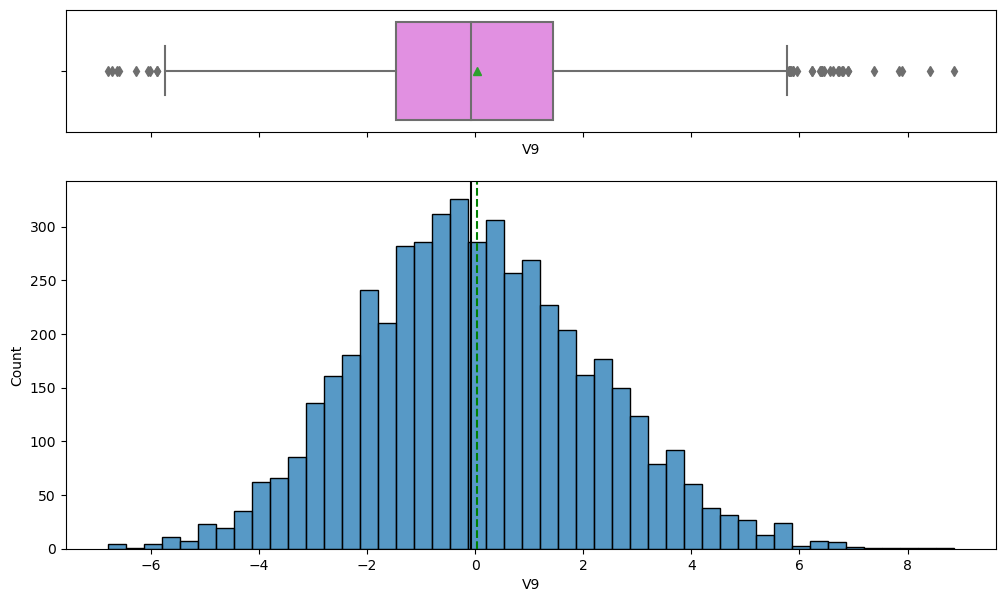

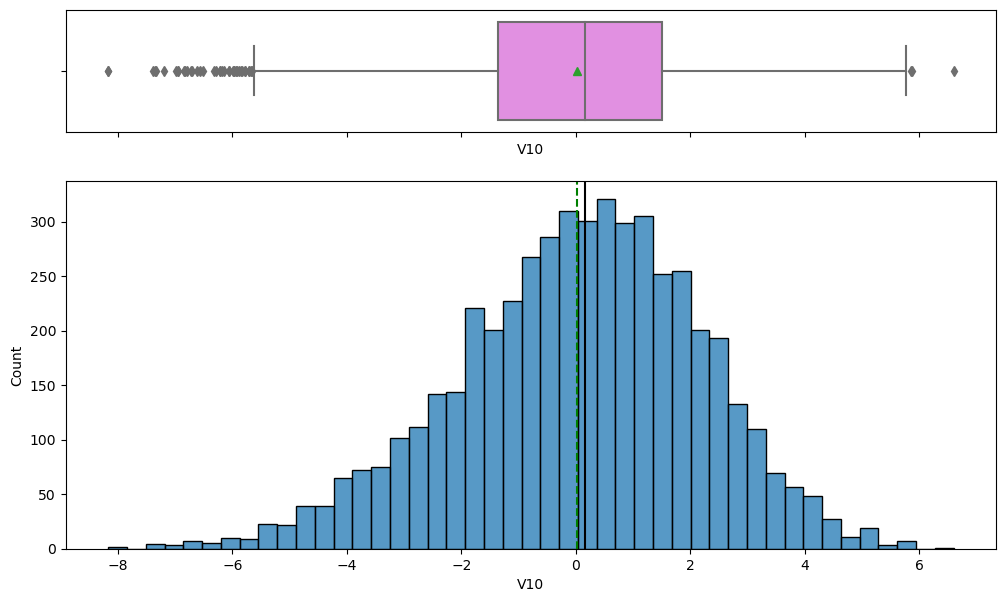

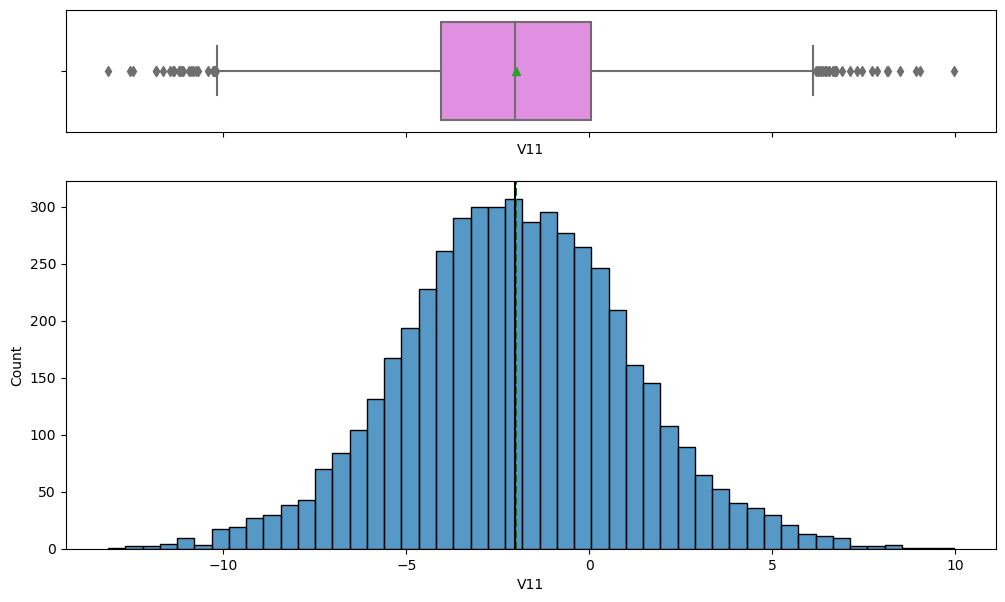

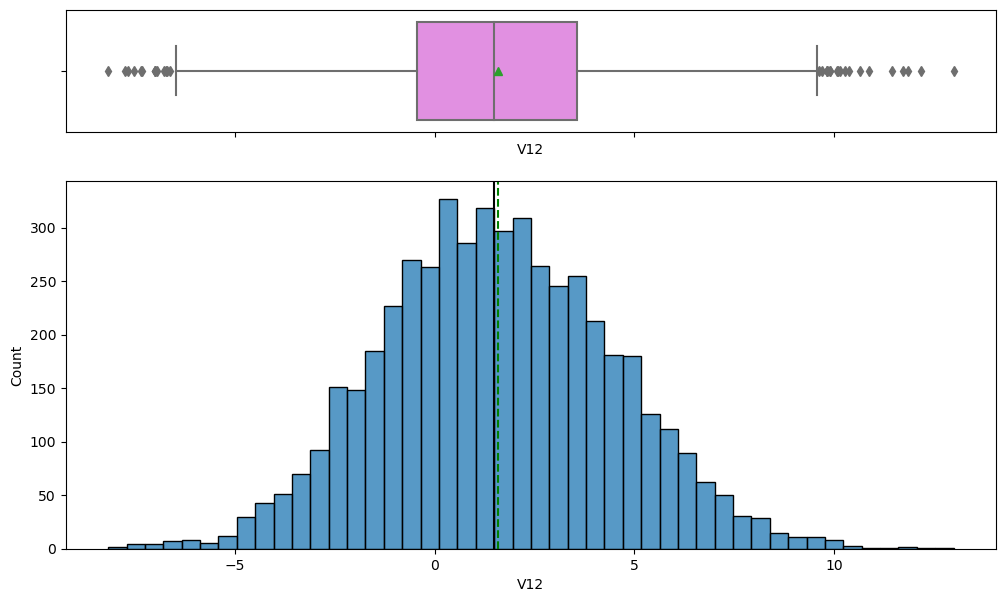

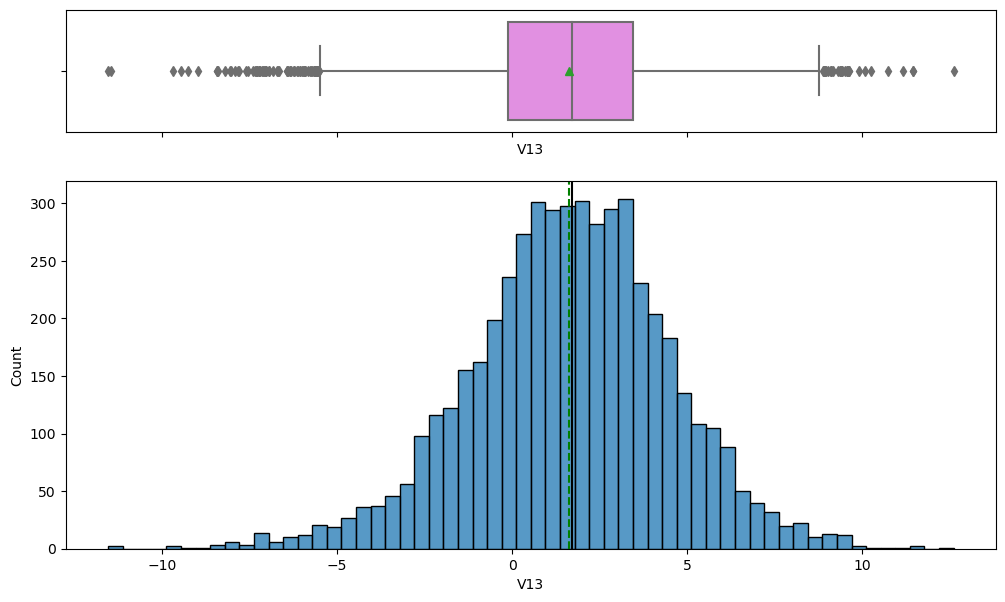

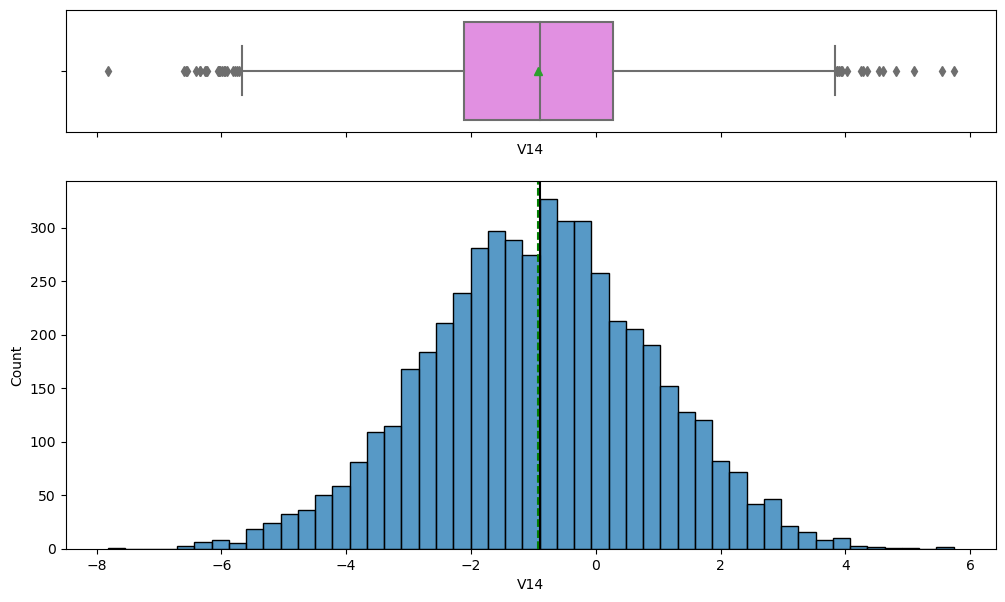

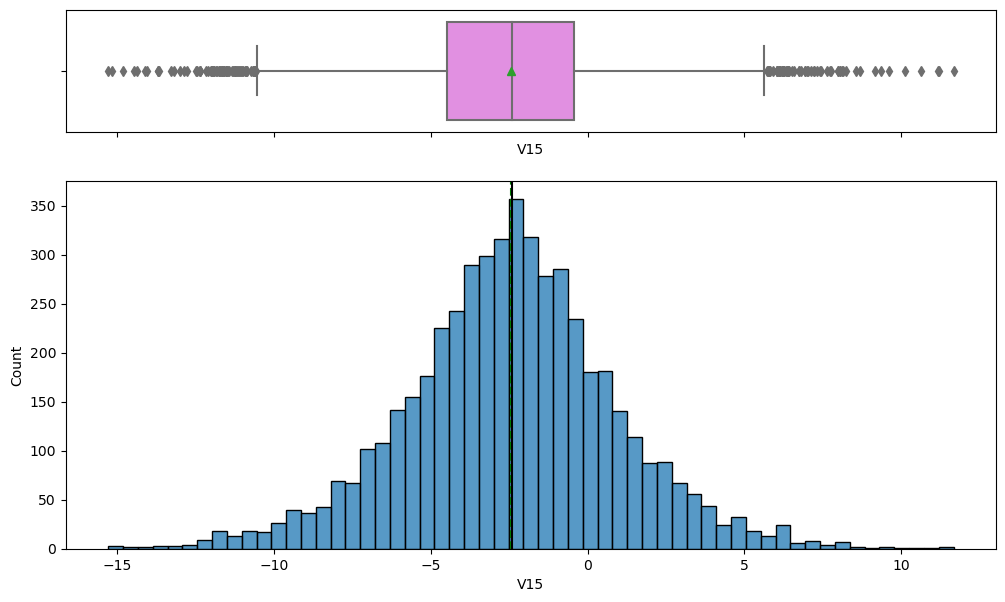

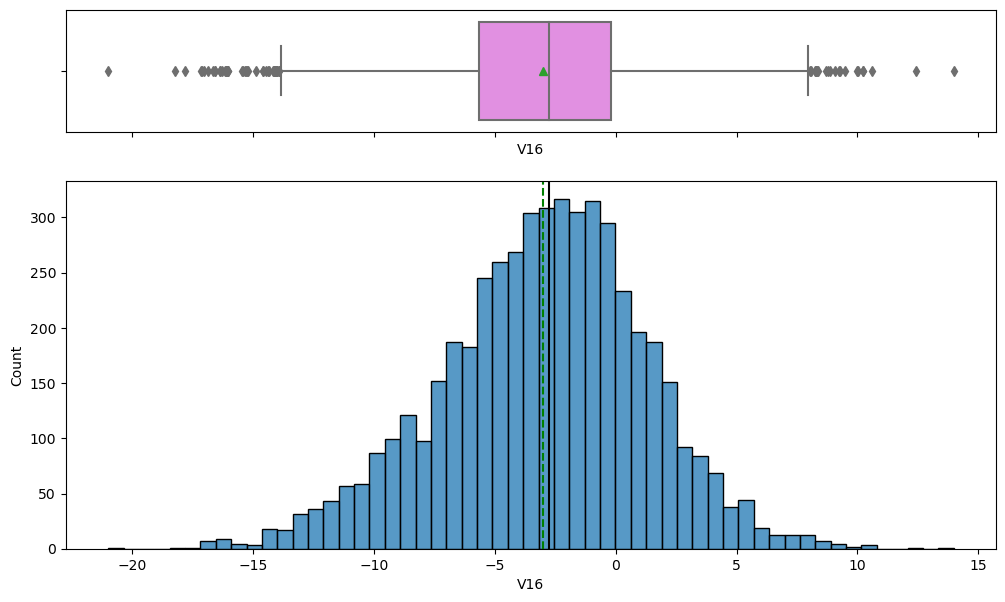

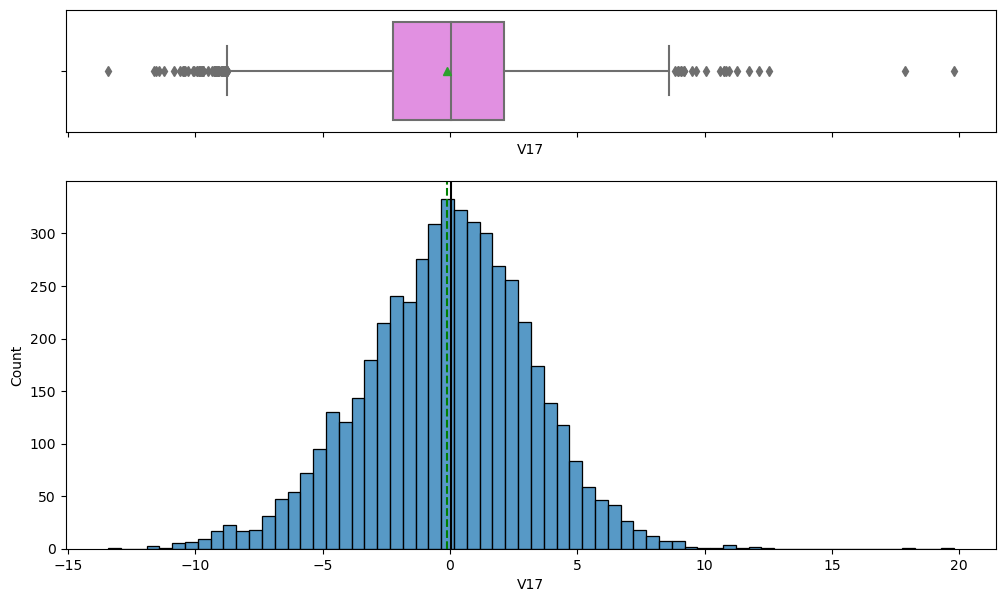

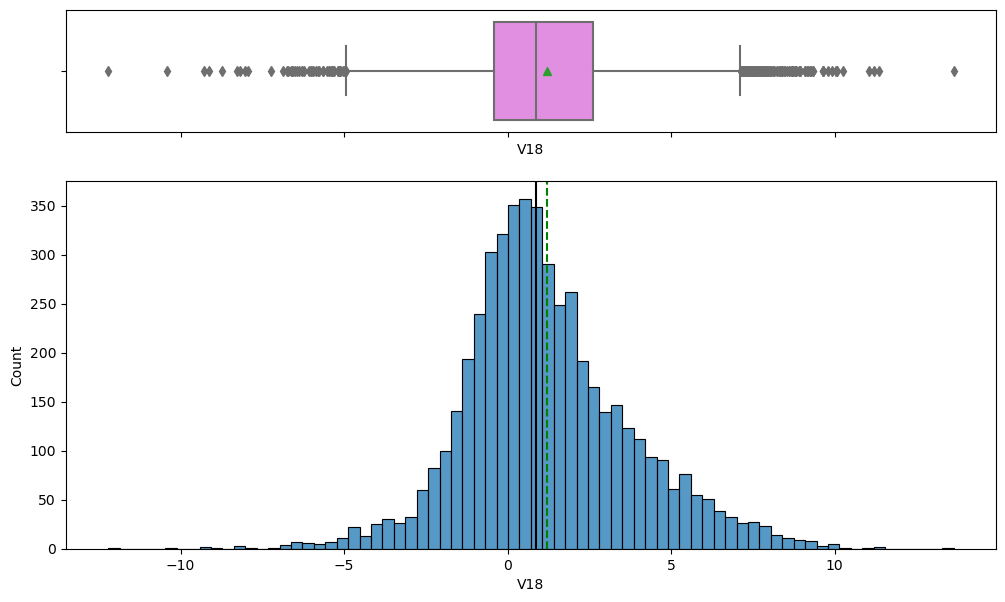

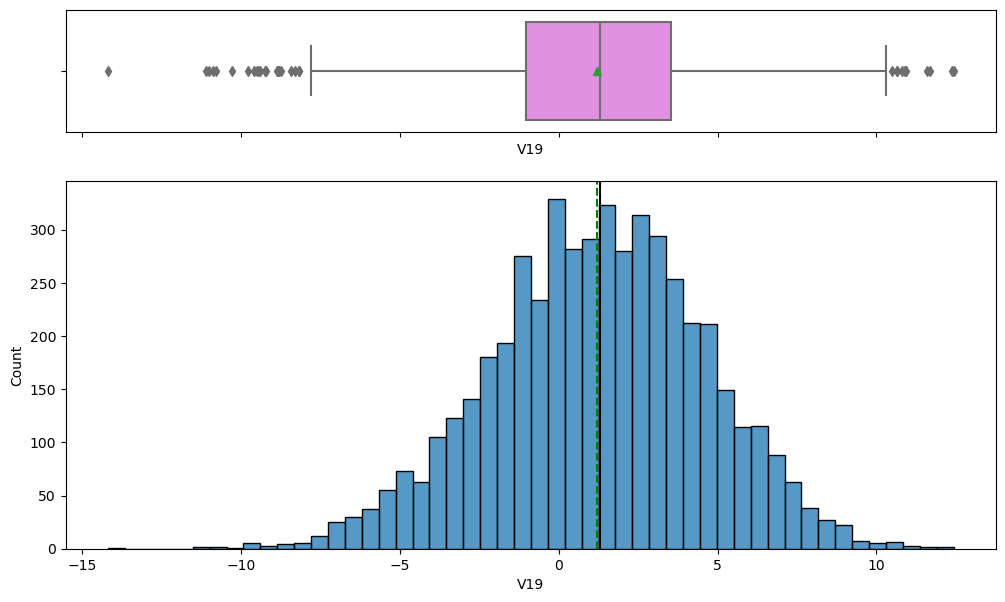

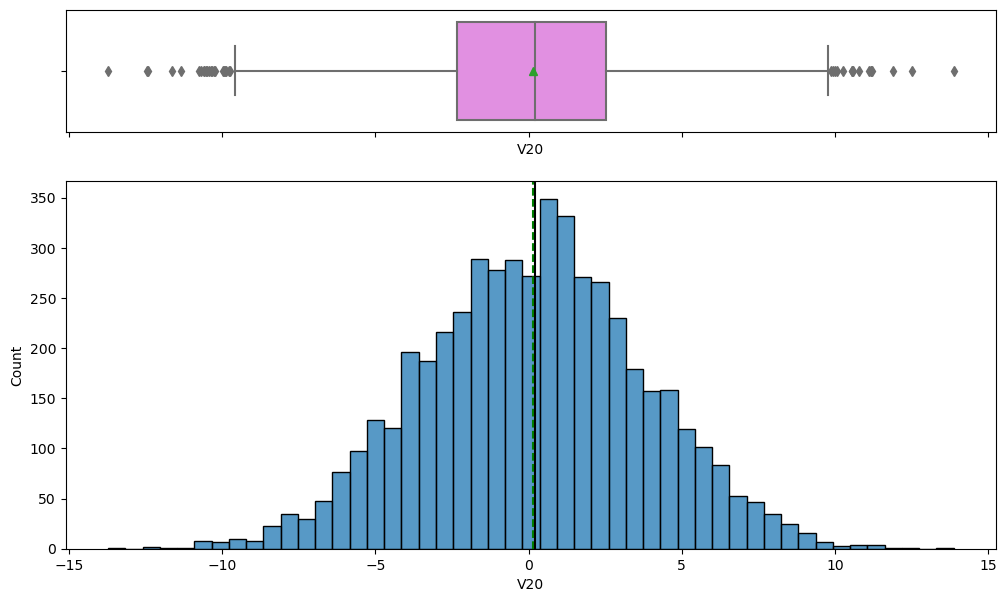

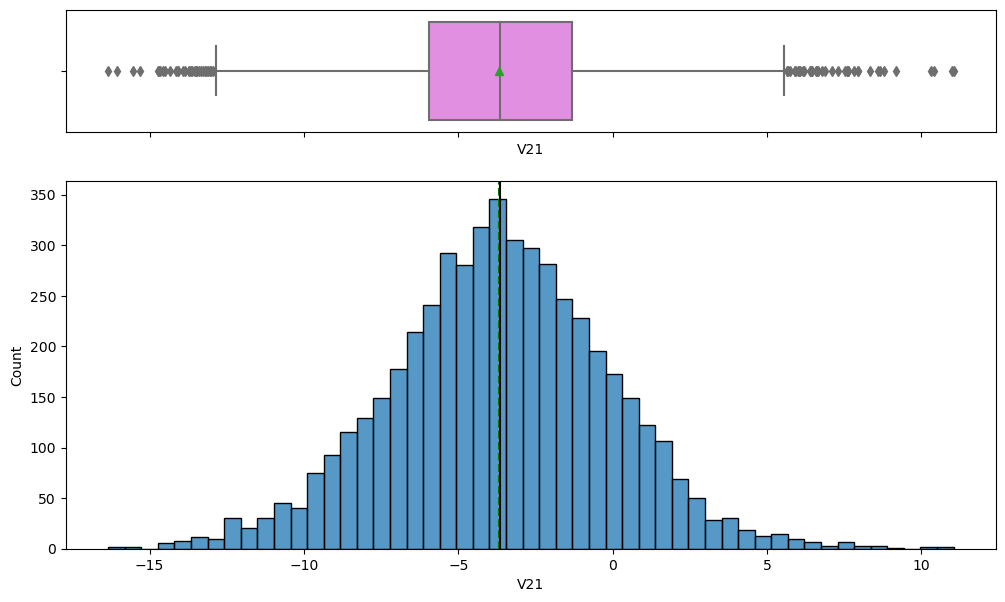

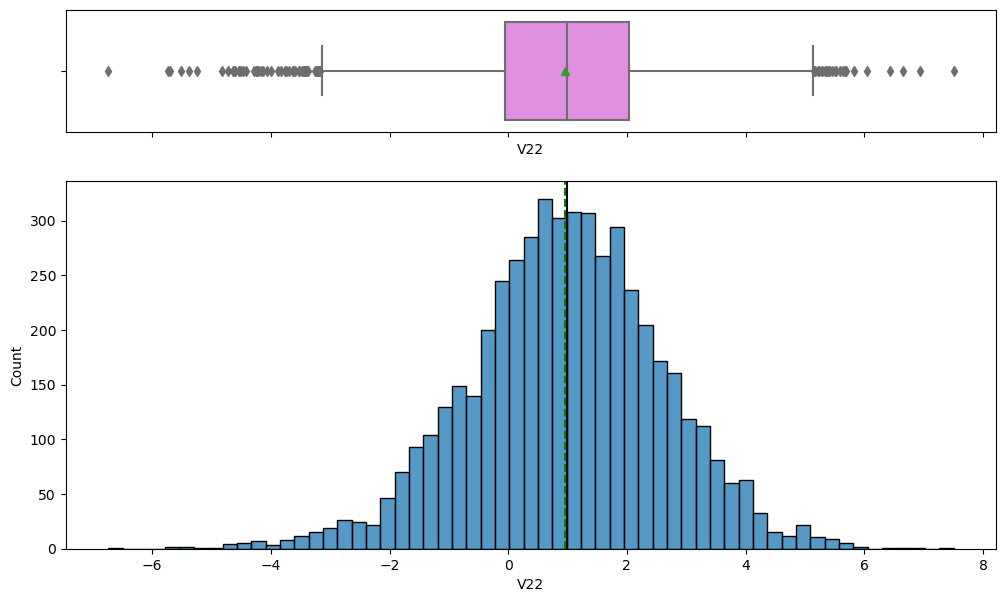

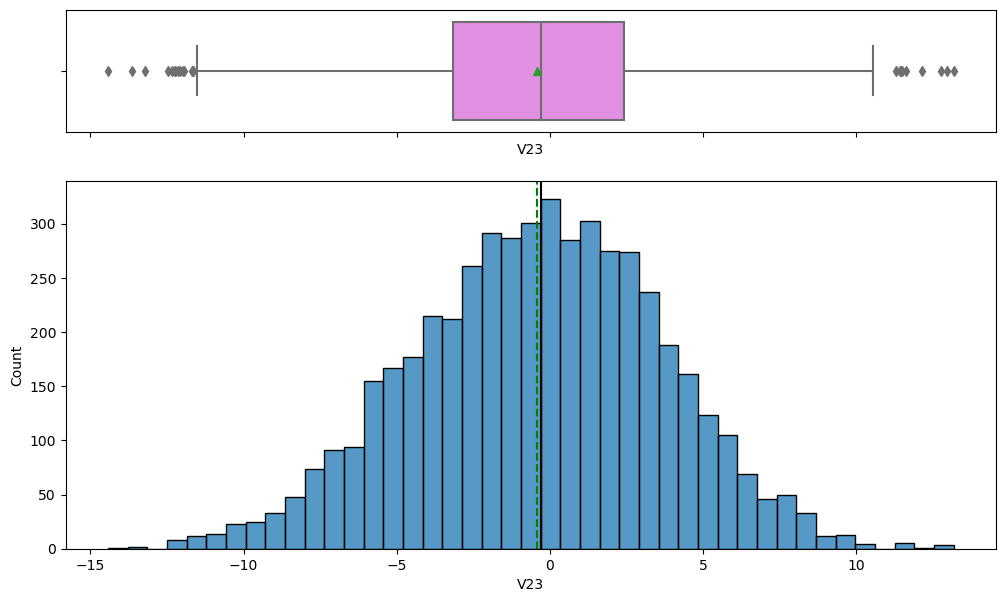

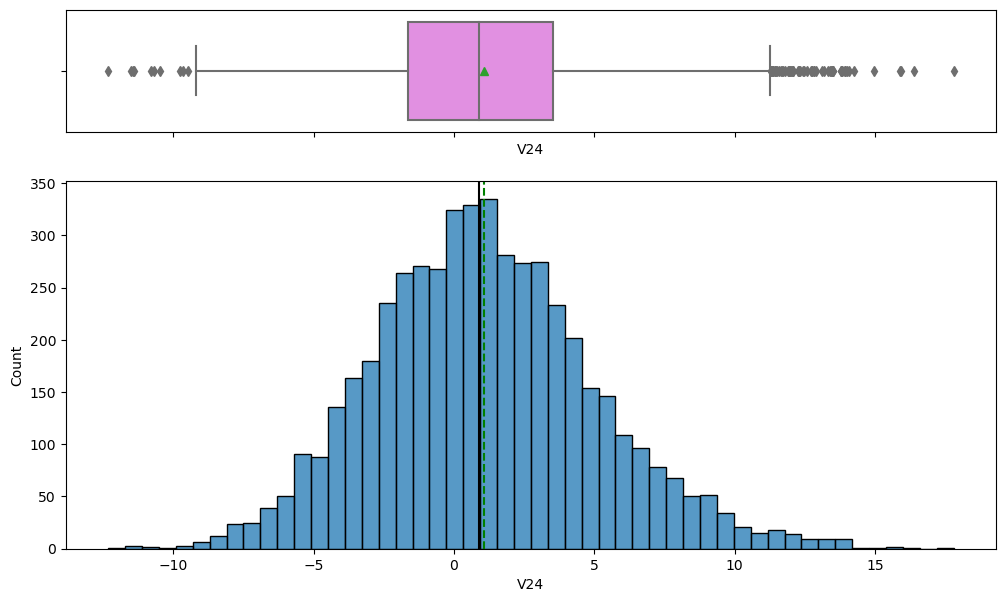

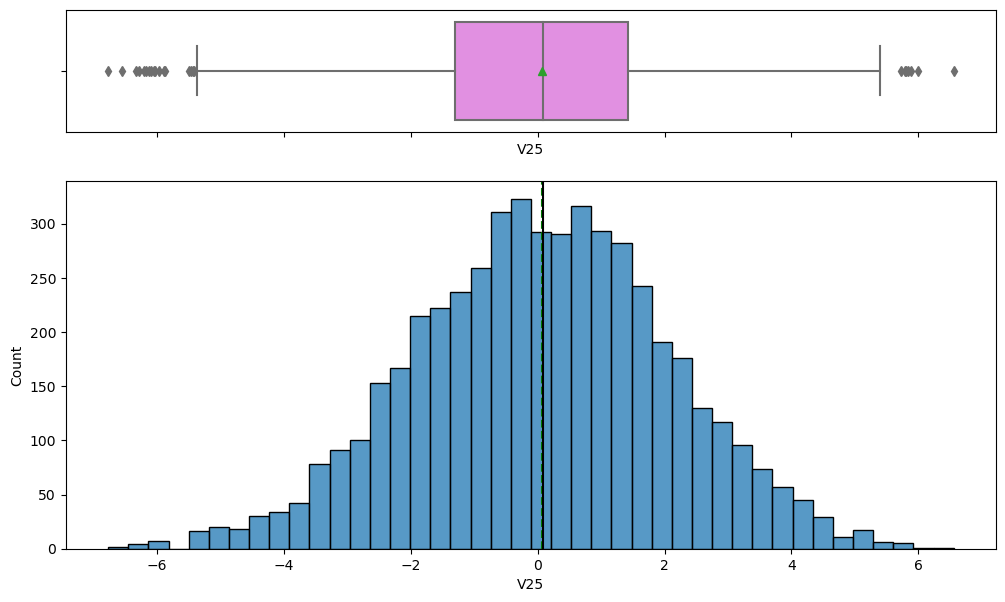

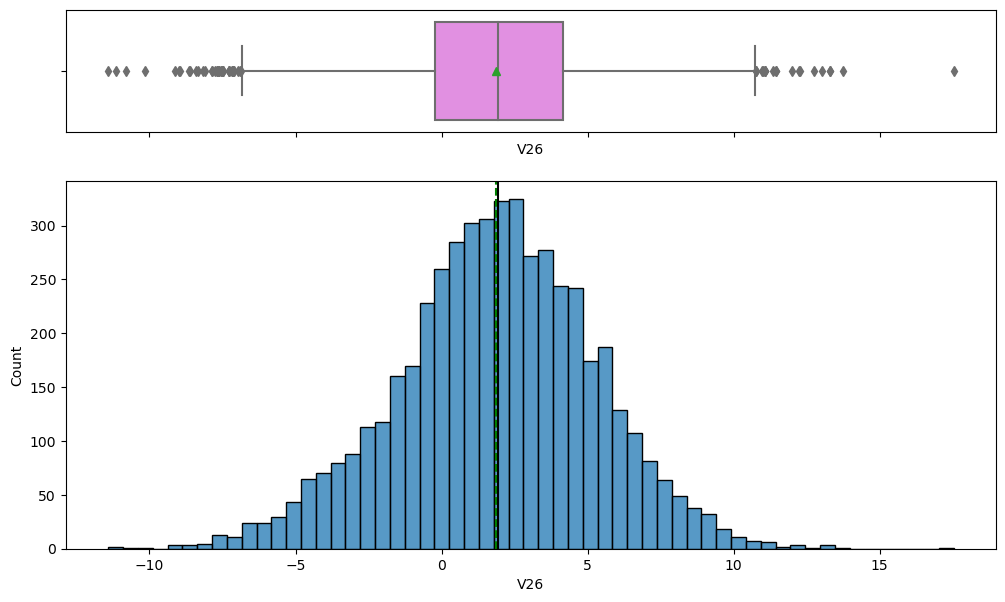

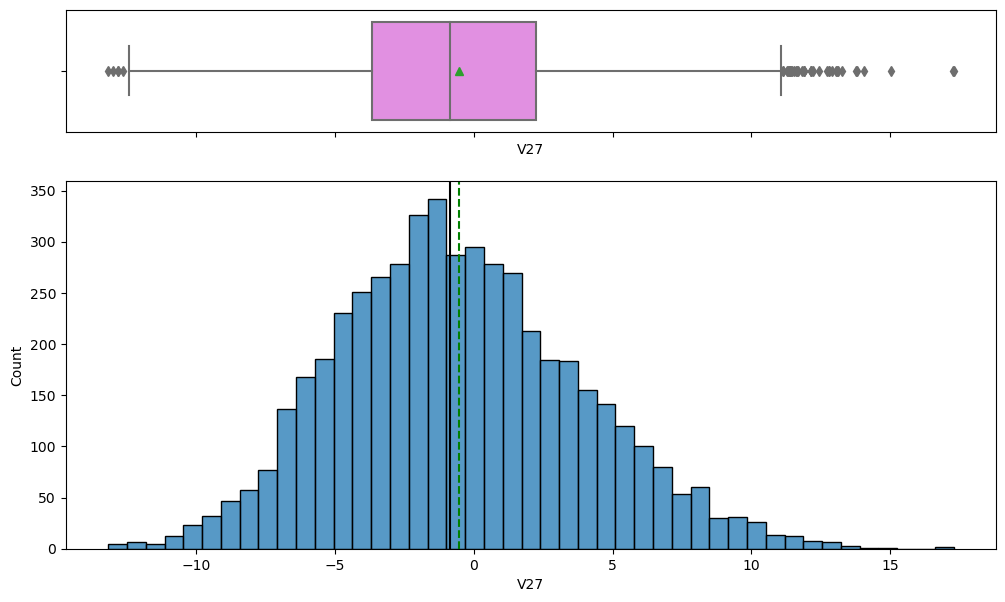

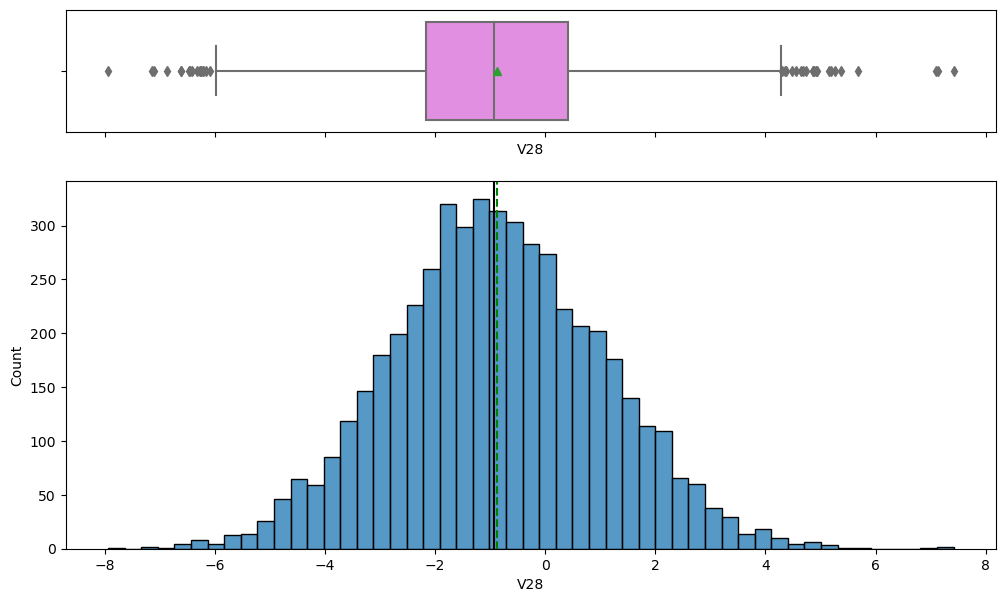

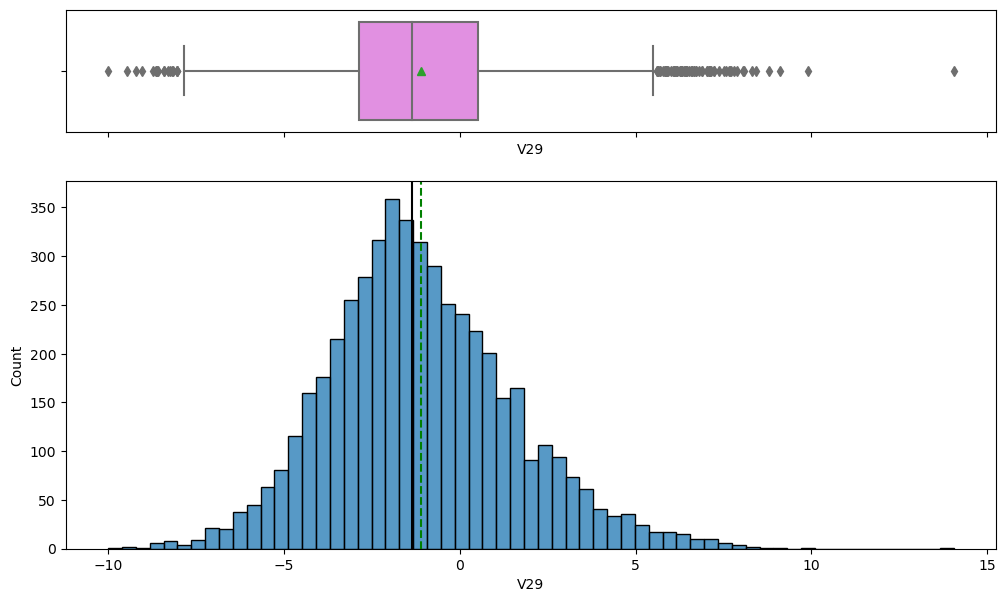

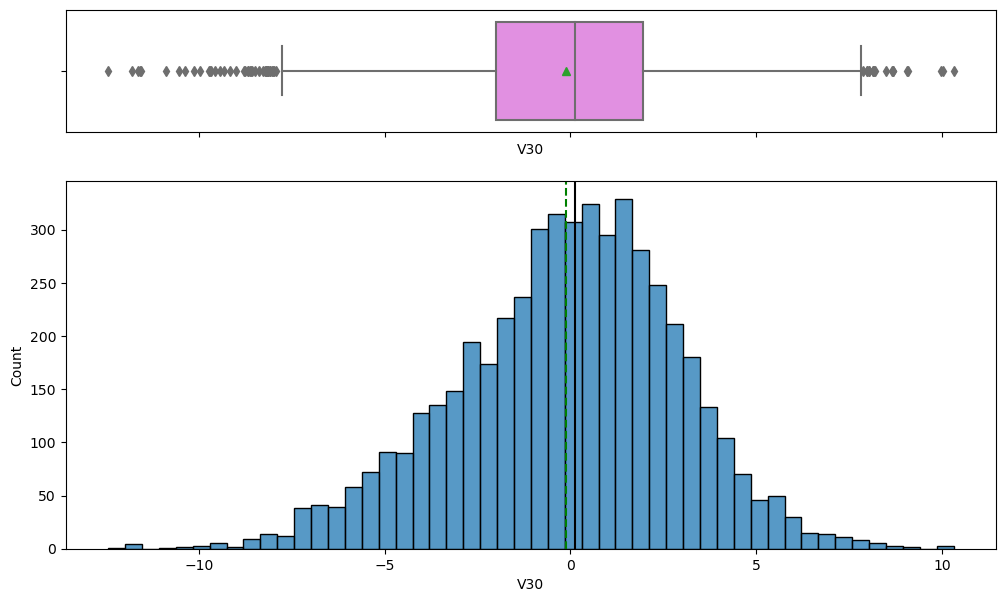

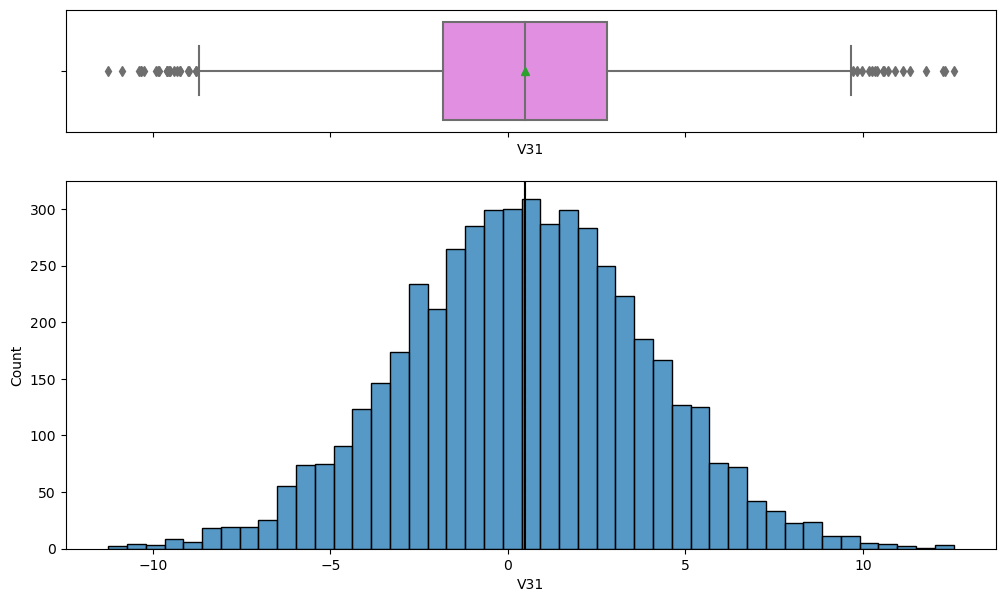

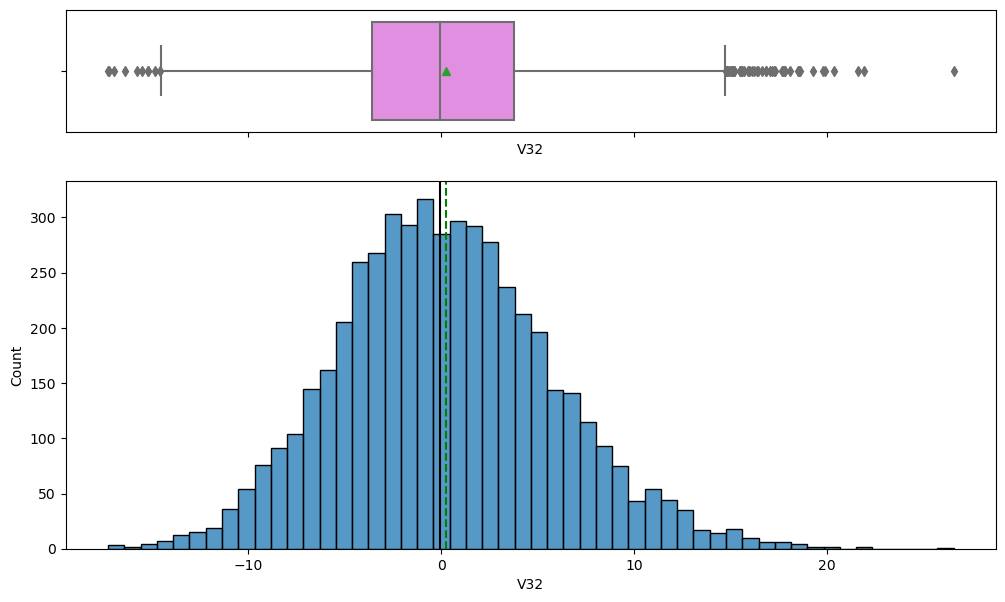

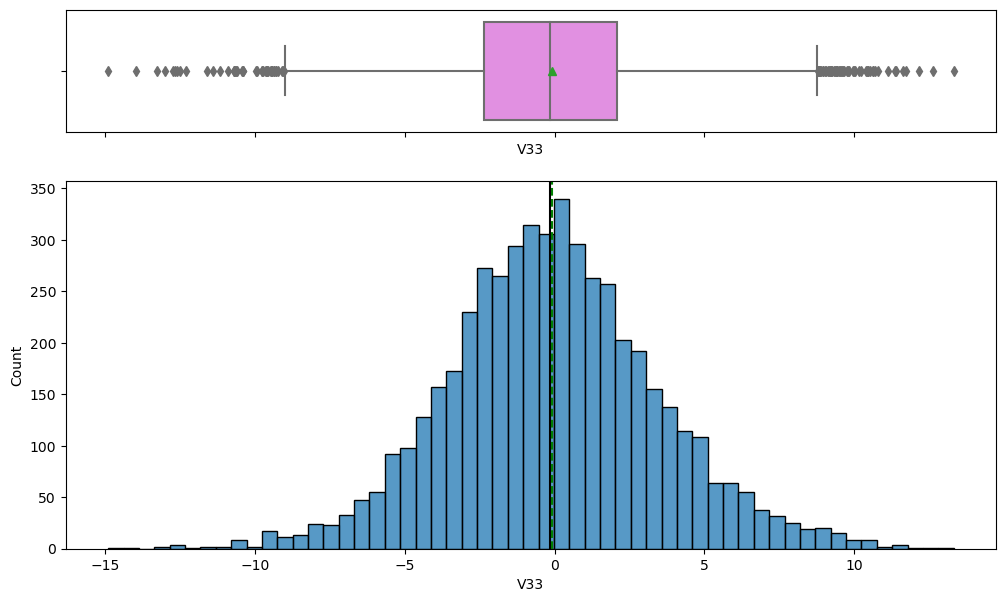

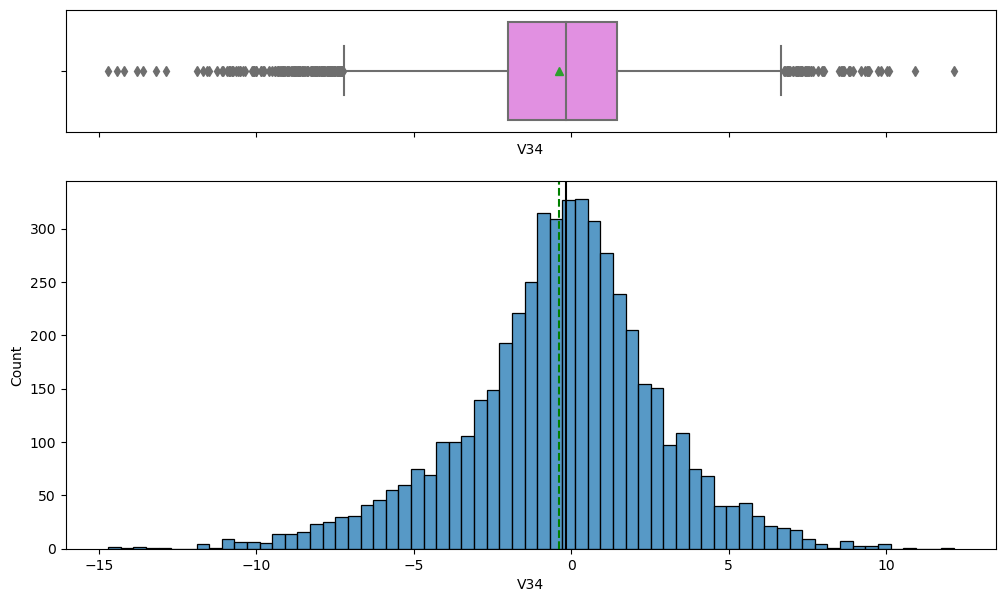

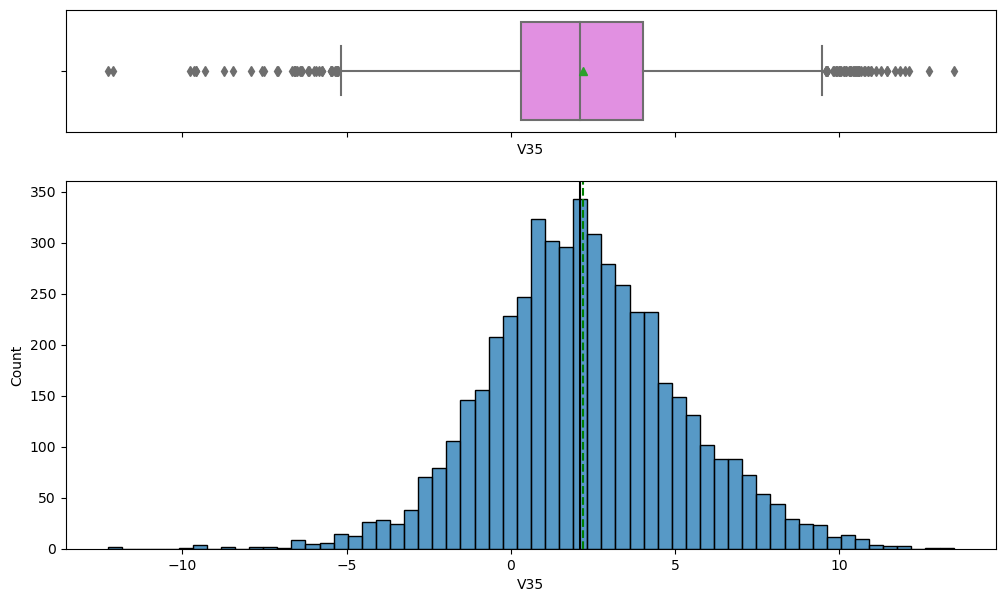

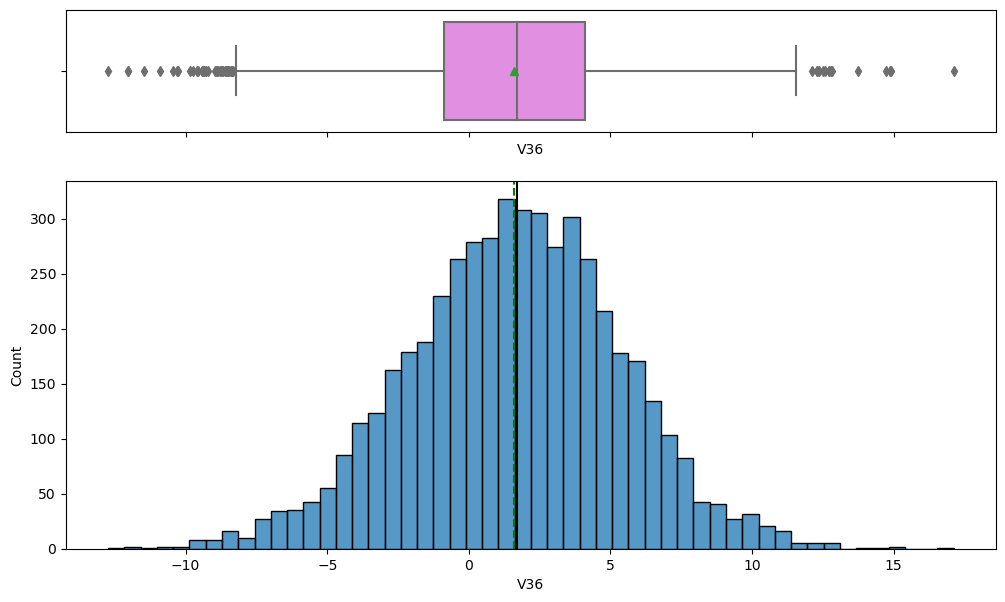

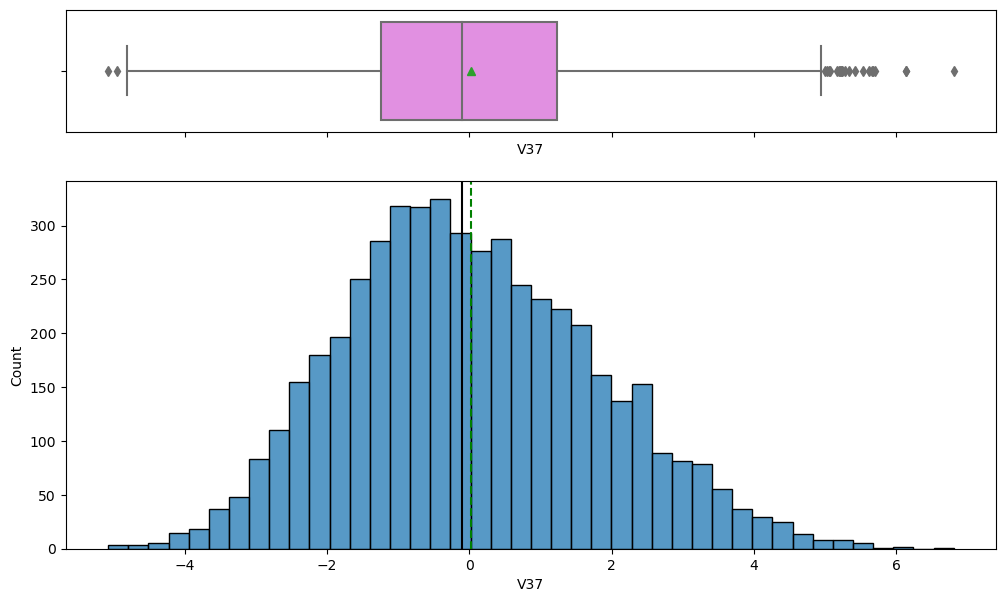

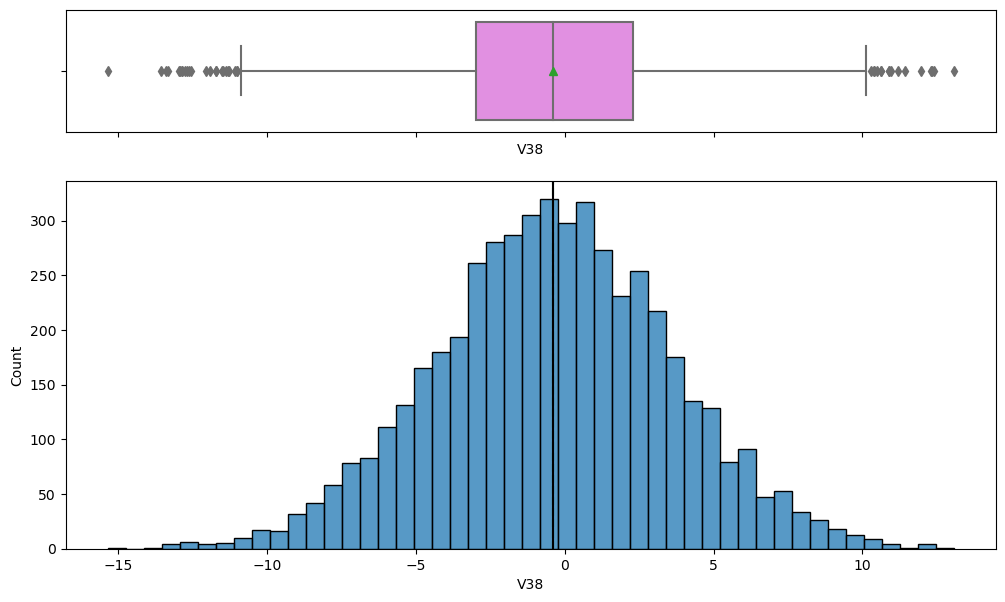

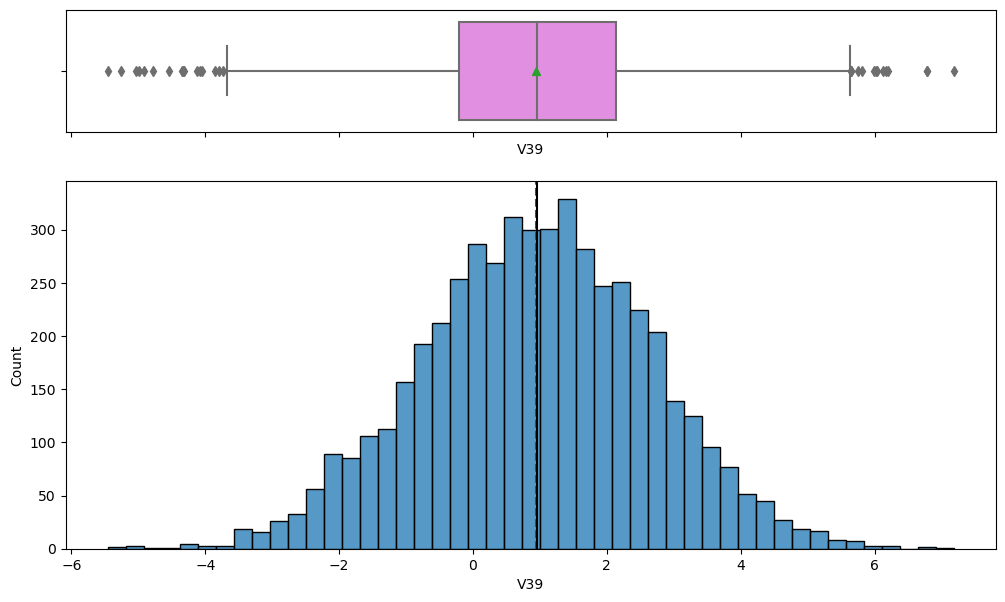

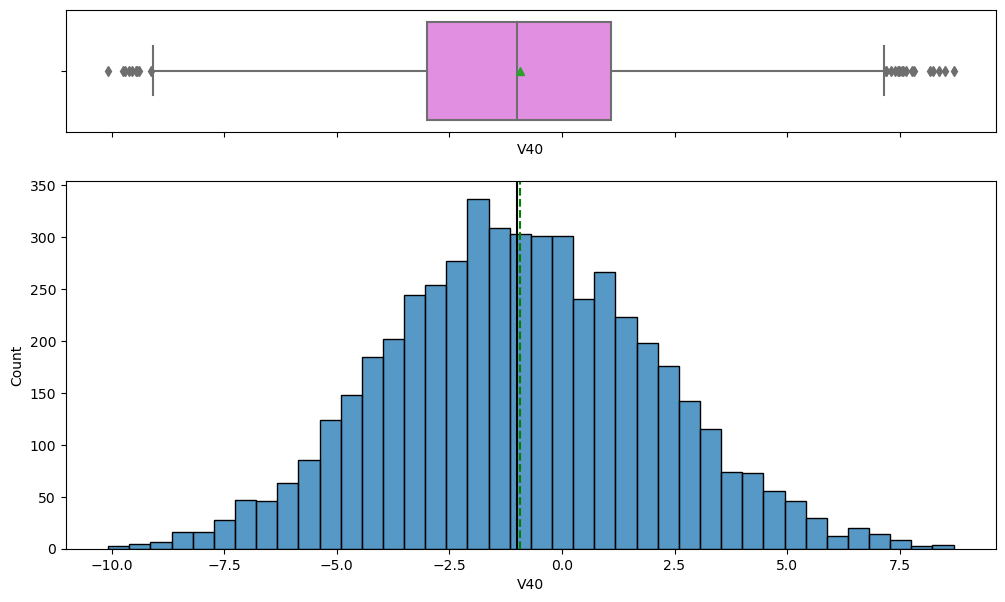

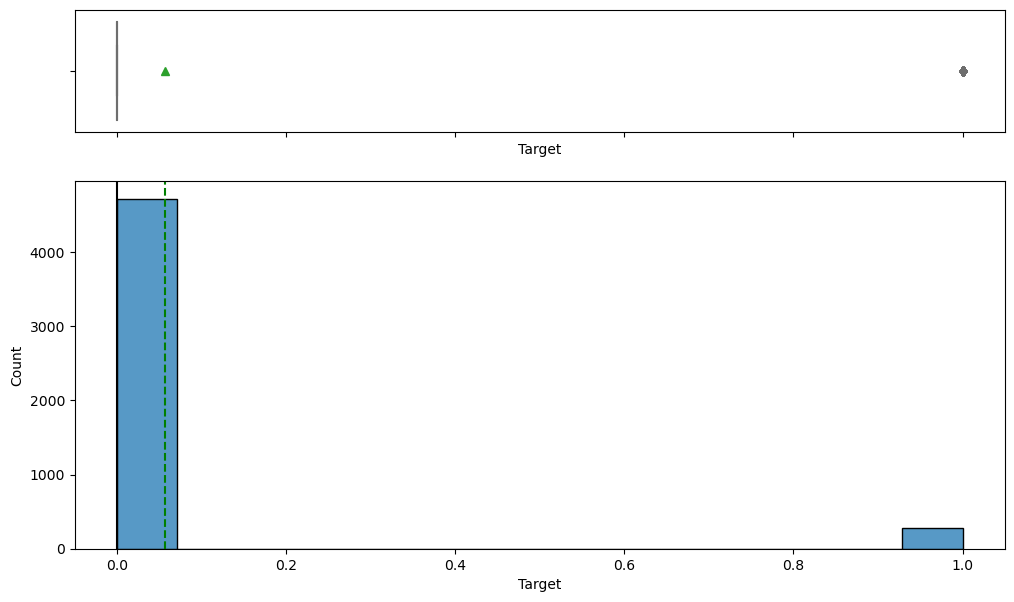

In [19]:
#plotting the histogram and boxplot for the test data
for feature in data_test.columns:
    hist_boxplot(data_test, feature, figsize=(12, 7), kde=False, bins=None)
    plt.show()

### As we can see from the graphs, almost all the variables in the data are normally distributed in Test Data

### Let's look at the values in target variable

In [20]:
#let's look at the target variable in the training data
data_train["Target"].value_counts(normalize = True)

0   0.945
1   0.056
Name: Target, dtype: float64

In [21]:
#let's look at the target variable in the testing data
data_test["Target"].value_counts(normalize = True)

0   0.944
1   0.056
Name: Target, dtype: float64

* The training data consists of 20000 observations in which 94.5% of the sensors indicated no errors while 5.5% sensors showed errors
* The test data consists of 5000 observations in which 94.4% of the sensors indicated no errors while 5.6% sensors showed errors

## Data Pre-Processing

### Getting the training data ready for preprocessing
### Since, we aleady have a test dataset provided so we will not be splitting the data into train and test, instead we will split the provided training data into validation data as well

In [22]:
# Dividing train data into X and y 
X = data_train.drop(["Target"], axis=1)
y = data_train["Target"]

In [23]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510


In [24]:
y

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       0
12       0
13       0
14       1
15       0
16       1
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       1
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       0
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       1
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       1
88       0
89       0
90       0

### Getting the training data ready for preprocessing

In [25]:
X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

In [27]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: Target
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


#### Since the data is already provided in the training and testing data we will be splitting the data into training and validation set

In [28]:
# Splitting train dataset into training and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2 ,random_state = 1, stratify = y)

print(X_train.shape,X_val.shape)

(16000, 40) (4000, 40)


In [29]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 16000 entries, 5949 to 727
Series name: Target
Non-Null Count  Dtype
--------------  -----
16000 non-null  int64
dtypes: int64(1)
memory usage: 250.0 KB


In [30]:
y_val.info()

<class 'pandas.core.series.Series'>
Int64Index: 4000 entries, 10019 to 10419
Series name: Target
Non-Null Count  Dtype
--------------  -----
4000 non-null   int64
dtypes: int64(1)
memory usage: 62.5 KB


## Missing value imputation
* For the imputing method we will replace the missing values with Median of the feature

In [31]:
# selecting the imputer strategy
imputer = SimpleImputer(strategy="median")

In [32]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [33]:
# After imputing let's make sure that there is no missing values in the training,Validation and Test data
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

In [34]:
# Let's look at the class distribution for the data
print("Target value ration in y")
print(y.value_counts(1))
print("*" * 30)
print("Target value ration in y_train")
print(y.value_counts(1))
print("*" * 30)
print("Target value ration in y_val")
print(y.value_counts(1))
print("*" * 30)
print("Target value ration in y_test")
print(y.value_counts(1))
print("*" * 30)

Target value ration in y
0   0.945
1   0.056
Name: Target, dtype: float64
******************************
Target value ration in y_train
0   0.945
1   0.056
Name: Target, dtype: float64
******************************
Target value ration in y_val
0   0.945
1   0.056
Name: Target, dtype: float64
******************************
Target value ration in y_test
0   0.945
1   0.056
Name: Target, dtype: float64
******************************


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [35]:
# let's create a function to compute the performance of a classification model
def model_performance_classification_sklearn(model, predictors, target):
    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0],
    )

    return df_perf

In [36]:
def confusion_matrix_sklearn(model, predictors, target):
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [37]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

**We are now done with pre-processing and evaluation criterion, so let's start building the model.**

### Model Building on original data

In [38]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results = []
names = []
score = []

# loop through all models to get the mean cross validated score
print("\n" "CV performance on training dataset:" "\n")

for name, model in models:
    scoring = 'recall'
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    score.append((scores))
    print("{}: {}".format(name, scores))


CV performance on training dataset:

Logistic regression: 0.48988129245223133
Bagging: 0.7083222243382213
Random forest: 0.7195899193804354
GBM: 0.7173363803719928
Adaboost: 0.6215641465117756
Xgboost: 0.7995683361899321
dtree: 0.7196280073636767

Validation Performance:

Logistic regression: 0.49099099099099097
Bagging: 0.7207207207207207
Random forest: 0.7432432432432432
GBM: 0.7432432432432432
Adaboost: 0.6576576576576577
Xgboost: 0.8198198198198198
dtree: 0.7387387387387387


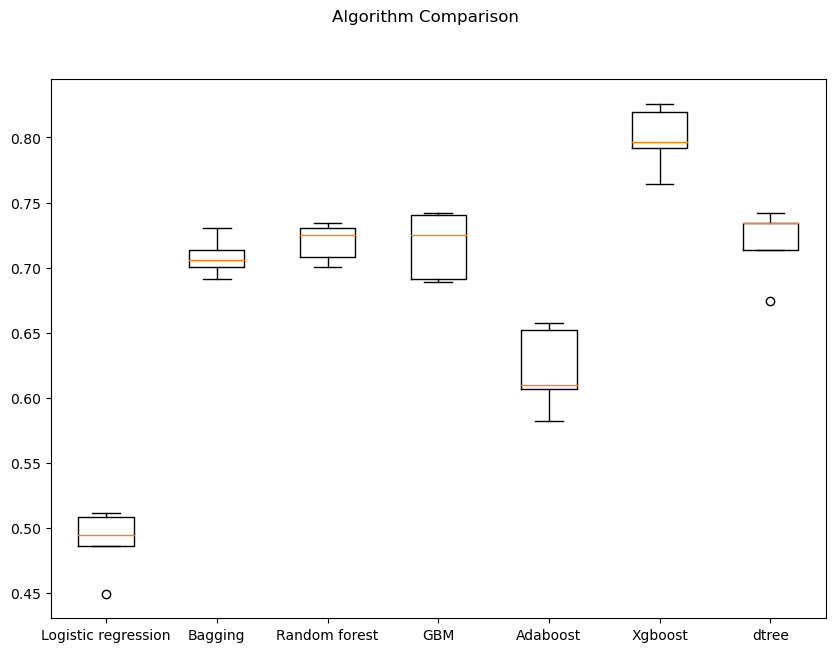

In [39]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

### Model Building with oversampled data
* Let's use the SMOTE method for over sampling 

In [40]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 888
Before OverSampling, counts of label '0': 15112 

After OverSampling, counts of label '1': 15112
After OverSampling, counts of label '0': 15112 

After OverSampling, the shape of train_X: (30224, 40)
After OverSampling, the shape of train_y: (30224,) 



In [41]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []
names = []
score = []

# loop through all models to get the mean cross validated score
print("\n" "CV performance on OS training dataset:" "\n")

for name, model in models:
    scoring = 'recall'
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance OS dataset:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


CV performance on OS training dataset:

Logistic regression: 0.8812865538044636
Bagging: 0.9781630048735123
Random forest: 0.9855744607906776
GBM: 0.9239674518302545
Adaboost: 0.8935280870047044
Xgboost: 0.9903390573001649
dtree: 0.9732668119313808

Validation Performance OS dataset:

Logistic regression: 0.8513513513513513
Bagging: 0.8423423423423423
Random forest: 0.8558558558558559
GBM: 0.8828828828828829
Adaboost: 0.8558558558558559
Xgboost: 0.8648648648648649
dtree: 0.8198198198198198


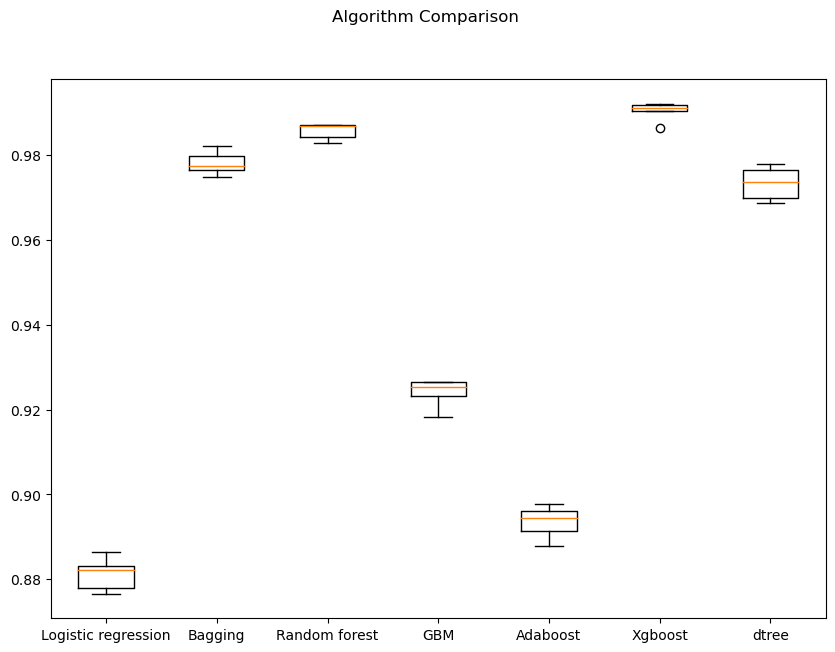

In [42]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with undersampled data
* Let's use Random Under Sampler to create an undersampled data for model fitting 

In [43]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 888
Before UnderSampling, counts of label '0': 15112 

After UnderSampling, counts of label '1': 888
After UnderSampling, counts of label '0': 888 

After UnderSampling, the shape of train_X: (1776, 40)
After UnderSampling, the shape of train_y: (1776,) 



In [44]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results2 = []
names = []
score = []

# loop through all models to get the mean cross validated score
print("\n" "CV performance on US training dataset:" "\n")

for name, model in models:
    scoring = 'recall'
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance on US dataset:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


CV performance on US training dataset:

Logistic regression: 0.8513235574176348
Bagging: 0.8704627689963816
Random forest: 0.8975052370976957
GBM: 0.8907446200723672
Adaboost: 0.8715927124992063
Xgboost: 0.8952707420808734
dtree: 0.8468355233923697

Validation Performance on US dataset:

Logistic regression: 0.8648648648648649
Bagging: 0.8918918918918919
Random forest: 0.8783783783783784
GBM: 0.8873873873873874
Adaboost: 0.8558558558558559
Xgboost: 0.8918918918918919
dtree: 0.8468468468468469


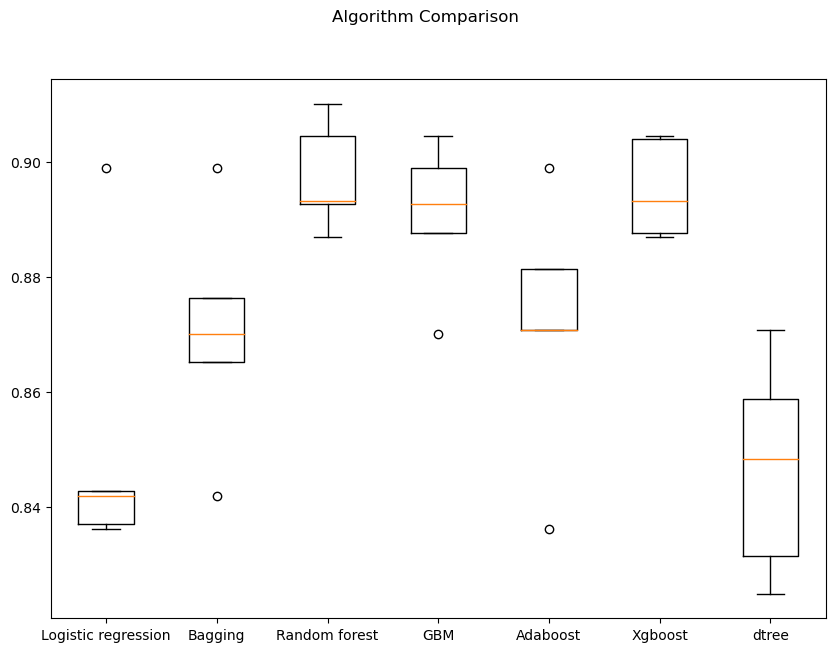

In [45]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names)

plt.show()

## Observations
### Logistic Regression
* The performance of both Training and Validation has increased when Oversampling is used 
### Bagging
* As seen from the model performance values the Bagging model shows more generalized performance in Under Sampled model
* Oversampled model performance is showing overfitting on the training data
### Random Forest
* Random Forest shows better performance in the under sampled model
* Same as Bagging Tuned model the over sampled tuned model is overfitting the training data
### GBM
* Gradient Boosting model shows better performance in the oversampled data 
### AdaBoost
* Same as GB Model AdaBoost is giving a better model performance on the oversampled data
### XGBoost
* XGBoost model is overfitting the oversampled data 
* While the XGBoost model is giving the best performance on Training and Validation for undersampled data
### Decision Tree
* Same as XGBoost, Decision Tree model shows overfitting on the oversampled data

## Hyperparameter Tuning

### From above Mentioned Models, Let's select 4 Models with better performance to perform Hyper Parameter Tuning
#### AdaBoost Model with Over Sampled Data
#### Random Forest  Model with Under Sampled Data
#### Gradient Boosting Model with Over Sampled Data
#### XGBoost Model with Under Sampled Data

### Tuning AdaBoost using oversampled data

In [46]:
%%time 

# Defining AdaBoost Model
Model = AdaBoostClassifier(random_state=1)

# Parameters for Random Search CV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting the model 
randomized_cv.fit(X_train_over,y_train_over)
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9693618503452355:
Wall time: 9min 42s


In [47]:
# New pipeline with the best parameters

tuned_adb = AdaBoostClassifier(
    n_estimators= 200, learning_rate=0.2 , base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)
#fitting the oversampled data to the model
tuned_adb.fit(X_train_over,y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [48]:
adb_train_perf = model_performance_classification_sklearn(tuned_adb, X_train_over, y_train_over)
adb_train_perf

,Accuracy,Recall,Precision,F1
0,0.989,0.984,0.995,0.989


In [49]:
adb_val_perf = model_performance_classification_sklearn(tuned_adb, X_val, y_val)
adb_val_perf

,Accuracy,Recall,Precision,F1
0,0.982,0.856,0.819,0.837


### Tuning Random forest using Under Sampled data

In [50]:
%%time 

# Defining Random Forest model
Model = RandomForestClassifier(random_state=1)

# Parameters for Random Search CV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting the model
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.4, 'max_features': 'sqrt'} with CV score=0.8953278740557353:
Wall time: 19.3 s


In [51]:
# Creating new pipeline with best parameters
tuned_rf = RandomForestClassifier(
    max_features=0.2,
    random_state=1,
    max_samples=0.4,
    n_estimators=300,
    min_samples_leaf=1,
)
tuned_rf.fit(X_train_un,y_train_un)

RandomForestClassifier(max_features=0.2, max_samples=0.4, n_estimators=300,
                       random_state=1)

In [52]:
rf_train_perf = model_performance_classification_sklearn(tuned_rf,X_train_un,y_train_un)
rf_train_perf

,Accuracy,Recall,Precision,F1
0,0.966,0.937,0.995,0.965


In [53]:
rf_val_perf = model_performance_classification_sklearn(tuned_rf,X_val,y_val)
rf_val_perf

,Accuracy,Recall,Precision,F1
0,0.935,0.883,0.456,0.601


### Tuning Gradient Boosting using Over Sampled data

In [54]:
%%time 

#let's define the gradient boosting model
Model = GradientBoostingClassifier(random_state=1)


param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.3,0.5,0.7], "max_features":[0.5,0.7]}


randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)


randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 1} with CV score=0.9708836489188448:
Wall time: 5min 12s


In [55]:
# Creating new pipeline with best parameters
tuned_gbm = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

tuned_gbm.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=1, max_features=0.7, n_estimators=125,
                           random_state=1, subsample=0.7)

In [56]:
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm,X_train_un,y_train_un)
gbm_train_perf

,Accuracy,Recall,Precision,F1
0,0.980,0.971,0.989,0.980


In [57]:
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm,X_val,y_val)
gbm_val_perf

,Accuracy,Recall,Precision,F1
0,0.864,0.842,0.268,0.407


### Tuning XGBoost using Under Sampled data

In [58]:
%%time 


Model = XGBClassifier(random_state=1,eval_metric='logloss')


param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}


randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)


randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9279565796991049:
Wall time: 22.7 s


In [59]:
xgb = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=5,
)

xgb.fit(X_train_un,y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [60]:
xgb_train_perf = model_performance_classification_sklearn(xgb,X_train_un,y_train_un)
xgb_train_perf

,Accuracy,Recall,Precision,F1
0,0.980,1.000,0.961,0.980


In [61]:
xgb_val_perf = model_performance_classification_sklearn(xgb,X_val,y_val)
xgb_val_perf

,Accuracy,Recall,Precision,F1
0,0.837,0.914,0.243,0.383


**We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

In [62]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        adb_train_perf.T,
        rf_train_perf.T,
        gbm_train_perf.T,
        xgb_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost Model with Over Sampled Data",
    "Random Forest  Model with Under Sampled Data",
    "Gradient Boosting Model with Over Sampled Data",
    "XGBoost Model with Under Sampled Data"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost Model with Over Sampled Data,Random Forest Model with Under Sampled Data,Gradient Boosting Model with Over Sampled Data,XGBoost Model with Under Sampled Data
Accuracy,0.989,0.966,0.980,0.980
Recall,0.984,0.937,0.971,1.000
Precision,0.995,0.995,0.989,0.961
F1,0.989,0.965,0.980,0.980


In [63]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        adb_val_perf.T,
        rf_val_perf.T,
        gbm_val_perf.T,
        xgb_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "AdaBoost Model with Over Sampled Data",
    "Random Forest  Model with Under Sampled Data",
    "Gradient Boosting Model with Over Sampled Data",
    "XGBoost Model with Under Sampled Data"
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,AdaBoost Model with Over Sampled Data,Random Forest Model with Under Sampled Data,Gradient Boosting Model with Over Sampled Data,XGBoost Model with Under Sampled Data
Accuracy,0.982,0.935,0.864,0.837
Recall,0.856,0.883,0.842,0.914
Precision,0.819,0.456,0.268,0.243
F1,0.837,0.601,0.407,0.383


### We are gonna use Recall and Precision as the measure of good performance because we want to avoid the Repair and Replacement costs 
* AdaBoost Model with Over Sampled Data

**Now we have our final model, so let's find out how our final model is performing on unseen test data.**

In [64]:
adb_test = model_performance_classification_sklearn(tuned_adb,X_test,y_test)
adb_test

,Accuracy,Recall,Precision,F1
0,0.981,0.840,0.826,0.833


### Feature Importances

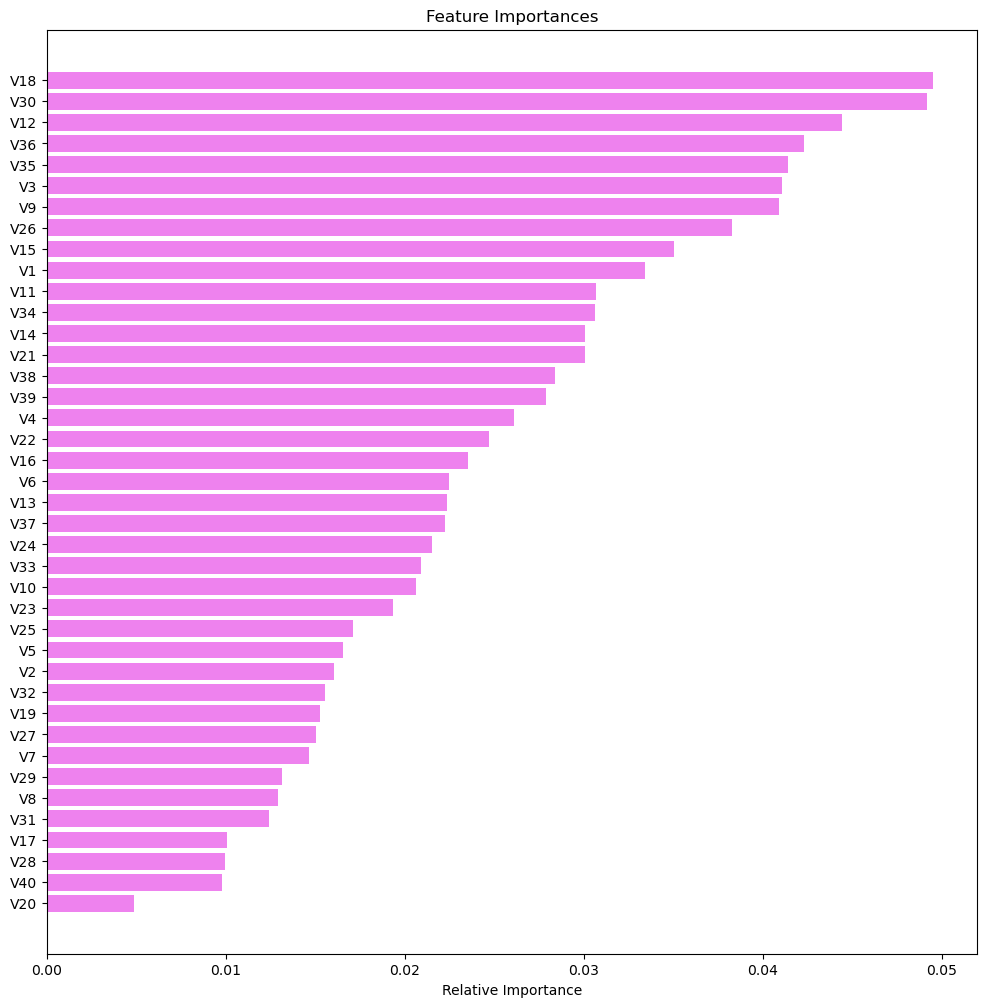

In [65]:
feature_names = X_train.columns
importances =  tuned_adb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Let's use Pipelines to build the final model

In [66]:
Pipeline_model = Pipeline([('scaler',StandardScaler()),
                           (('AdaBoost',AdaBoostClassifier(n_estimators= 200,
                                                           learning_rate=0.2,
                                                           base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)))])

In [67]:
X1 = data_train.drop(columns="Target")
Y1 = data_train["Target"]
X_test1 = data_test.drop(columns="Target")
y_test1 = data_test["Target"] 

In [68]:
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

In [69]:
#Oversampling using SMOTE
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

In [70]:
Pipeline_model.fit(X_over1,y_over1)

Pipeline(steps=[('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.2, n_estimators=200))])

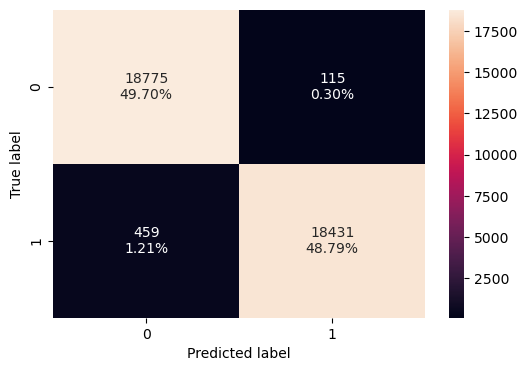

In [71]:
confusion_matrix_sklearn(Pipeline_model,X_over1,y_over1)

In [72]:
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model,X_test,y_test)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.978,0.851,0.774,0.811


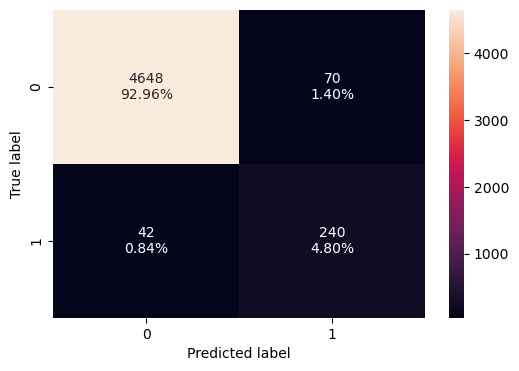

In [73]:
confusion_matrix_sklearn(Pipeline_model,X_test,y_test)

# Business Insights and Conclusions


* The task was to prepare a machine learning model that predicts the target variable, which is predicting the generator failures.
* The dataset has 20000 observations to prepare the ML model, which was tested on the test data with 5000 observations
* There were 18 missing values in each Feature `V1`,`V2` of the training data which is total of 0.18% of the total data set, while there were 5 missing values in Feature `V1` and 6 missing values in Feature `V2` of the testing data, which is total of 0.22% of the test data set
* As provided in the project statement, these were the predictions and their outcomes, the higher impact predicitons will be False Negative which will result in the higher replacement cost and . so recall should be the best measure to evaluate the model performance, higher the recall the less number of the False Negatives
    *True positives (TP) are failures correctly predicted by the model. These will result in repairing costs
    *False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs
    *False positives (FP) are detections where there is no failure. These will result in inspection costs
* The model that has been chosen is Tuned Adaboost model with Over sampeled data. which is providing almost 85% of the recall score and 77% percent of precision. Which means the model is minimizing the False Negatives and providing with an increased number of the True Positives.
* The Model tuning has been done using Random Search Cross Validation Hyperparameter, which takes less time to run compare to grid search.
* As seen the importance feature graph,features `V18`,`V30` and `V12` have higher influence in predicting the failure 